In [1]:
import json
import os
import time
from pprint import pprint

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import clear_output
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms

%matplotlib inline

# 1. Load metadata

Let us firsty load data all the required metadata 

In [2]:
from typing import Any

BBOX = list[int]
IMAGE_DETECTIONS = dict[str, Any]

In [3]:
DATA_PATH = '../../data'

TEST_IMAGES_PATH = f'{DATA_PATH}/test/images'
TEST_INFO_PATH = f'{DATA_PATH}/metadata/metadata/iwildcam2022_test_information.json'

DETECTIONS_INFO_PATH = f'{DATA_PATH}/metadata/metadata/iwildcam2022_mdv4_detections.json'

In [4]:
with open(TEST_INFO_PATH) as file:
    test_info = json.load(file)

test_images_info = test_info['images']

In [5]:
with open(DETECTIONS_INFO_PATH) as file:
    detections_info = json.load(file)

image_detections_info = detections_info['images']

## Synchronize images info

Since the actual number of images in _train_ and _test_ directories is different from original (after dataset reduction) and metadata refers to the whole dataset, let us synchronize it

In [6]:
IMAGE_INFO = dict[str, str | int]


def sync_images_info(images_info: list[IMAGE_INFO], directory: str) -> list[IMAGE_INFO]:
    result = []
    for image_info in images_info:
        file_path = f'{directory}/{image_info["file_name"]}'    
        if os.path.isfile(file_path):
            result.append(image_info)
    return result

In [7]:
test_images_info = sync_images_info(test_images_info, TEST_IMAGES_PATH)
print(f'Number of test images = {len(test_images_info)}')

Number of test images = 4440


Let us convert detections metadata to a bit more convenient format, namely to Python's dictionary.  
It will give us an opportunity to get image bounding boxes by its ID in an easy way

In [8]:
from typing import Any

IMAGE_DETECTIONS = dict[str, Any]


def convert_image_detections_info(image_detections_info: list[dict]) -> dict[str, IMAGE_DETECTIONS]:
    result = dict()
    for info in image_detections_info:
        file_name = info['file']
        image_id = file_name.split('/')[1].split('.')[0]
        result[image_id] = info['detections']
    return result

In [9]:
detections = convert_image_detections_info(image_detections_info)

# 2. Metrics

## 2.1 Intersection over union

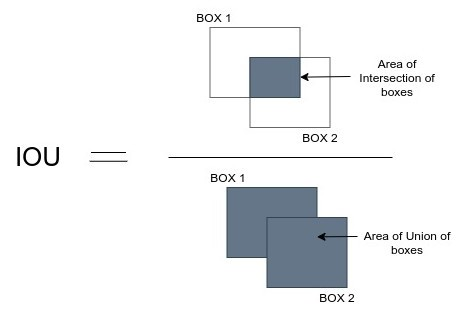

In [10]:
def iou(true_bboxes: list[BBOX], pred_bboxes: list[BBOX]) -> float:
    result = 0
    true_bboxes = torch.tensor(true_bboxes)
    for bbox in pred_bboxes:
        pred_bbox = torch.tensor(bbox).reshape(1,-1)
        result += float(metrics.bbox_iou(pred_bbox, true_bboxes, xywh=True).min())
    return result / len(pred_bboxes)

## 2.2 Custom mean squared error (MSE)

In [11]:
def mse(true_bboxes: list[BBOX], pred_bboxes: list[BBOX]) -> float:
    true_bboxes = np.array(true_bboxes)
    pred_bboxes = np.array(pred_bboxes)

    a = np.concatenate([pred_bboxes, np.arange(len(pred_bboxes)).reshape(-1, 1)], axis=1)
    b = np.concatenate([true_bboxes, np.arange(len(true_bboxes)).reshape(-1, 1)], axis=1)

    c = np.repeat(a, len(b), axis=0)
    d = np.tile(b, (len(a), 1))

    res = np.concatenate([c, d], axis=1)
    diff = ((res[:, [0,1]] - res[:, [5,6]]) ** 2).sum(axis=1) ** 0.5

    selected = [[],[]]
    res_mse = 0
    for i in np.argsort(diff):
        if (res[i][4] not in selected[0]) and (res[i][9] not in selected[1]):
            selected[0].append(res[i][4])
            selected[1].append(res[i][9])

            point = ((res[i][[0,1]] - res[i][[5,6]]) ** 2).sum()
            box = ((res[i][[2,3]] - res[i][[7,8]]) ** 2).sum()

            res_mse += (point + box)**0.5
        res_mse /= len(selected)
    return res_mse

## 2.3 Absolute value of difference between number of ground-truth objects and number of predicted objects

In [12]:
def num_found(y_true: list[BBOX], y_pred: list[BBOX]) -> int:
    return np.abs(len(y_true) - len(y_pred))

## Evaluation function 

In [13]:
def evaluate(y_true: list[list[BBOX]], y_pred: list[list[BBOX]]) -> dict:
    result = {
        "iou": [],
        "mse": [],
        "num_found": []
    }

    for true_bboxes, pred_bboxes in zip(y_true, y_pred):
        # one of the values is empty
        if (len(true_bboxes) != 0 and len(pred_bboxes) == 0) or (len(true_bboxes) == 0 and len(pred_bboxes) != 0):
            result["iou"].append(0)
            result["mse"].append(1)
            result["num_found"].append(num_found(true_bboxes, pred_bboxes))

        # both values are empty
        elif len(true_bboxes) == 0 and len(pred_bboxes) == 0:
            result["iou"].append(1)
            result["mse"].append(0)
            result["num_found"].append(0)

        else:
            result["iou"].append(iou(true_bboxes, pred_bboxes))
            result["mse"].append(mse(true_bboxes, pred_bboxes))
            result["num_found"].append(num_found(true_bboxes, pred_bboxes))

    return result

## Helper functions

In [14]:
def load_bboxes(labels_dir: str, image_id: str) -> list[BBOX]:
    bboxes = []

    file_path = f'{labels_dir}/{image_id}.txt'
    if os.path.isfile(file_path):
        with open(file_path, 'r') as file:
            for line in file:
                pred = list(map(float, line.split(' ')))
                bboxes.append(pred[1:])

    return bboxes


def get_labels(labels_dir: str, images_info: list[IMAGE_INFO]) -> list[list[BBOX]]:
    labels = []

    for image_info in images_info:
        image_id = image_info['id']
        bboxes = load_bboxes(labels_dir, image_id)
        labels.append(bboxes)

    return labels

In [15]:
def get_true_labels(images_info: list[IMAGE_INFO], detections: dict[str, IMAGE_DETECTIONS]) -> list[list[BBOX]]:
    labels = []

    for image_info in images_info:
        image_id = image_info['id']
        bboxes = get_bboxes(image_id, detections)
        labels.append(bboxes)

    return labels

In [16]:
ANIMAL_CATEGORY = '1'

In [17]:
def get_bboxes(image_id: str, detections: dict[str, IMAGE_DETECTIONS]) -> list[BBOX]:
    image_detections = detections[image_id]
    bboxes = [
        detection['bbox'] for detection in image_detections
        if detection['category'] == ANIMAL_CATEGORY and detection['conf'] > 0.5
    ]
    return bboxes

# 2. Tune hyperparameters

In order to achieve better performance we performed hyperparameter tuning with the use of Grid Search.  
Due to limitations of hardware we could not run thorough tuning, so we picked 3 hyperparameters with 2 different values for each of them.

Due to problem with GPU memory freeing after runs, we performed Grid Search with the use of bash script instead of running all the trainings one after another in one notebook. See _tuning.sh_. The results were saved in _runs/_ directory (_runs/exp/_, _runs/exp2/_...). All the runs had 3 epochs.

In [18]:
_ = os.system(f'tree -d runs/train')

runs/train
├── best
│   └── weights
├── exp
│   └── weights
├── exp2
│   └── weights
├── exp3
│   └── weights
├── exp4
│   └── weights
├── exp5
│   └── weights
├── exp6
│   └── weights
├── exp7
│   └── weights
└── exp8
    └── weights

18 directories


## 2.1 Run models on test data

Now let us check received weights on test set

In [19]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14166, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 14166 (delta 64), reused 83 (delta 50), pack-reused 14060
Receiving objects: 100% (14166/14166), 13.60 MiB | 4.96 MiB/s, done.
Resolving deltas: 100% (9727/9727), done.


In [20]:
!pip install -qr ./yolov5/requirements.txt

In [21]:
from yolov5 import train, val, detect
from yolov5.utils import metrics

In [22]:
RUN_NAMES = [
    'exp',
    'exp2',
    'exp3',
    'exp4',
    'exp5',
    'exp6',
    'exp7',
    'exp8'
]

In [23]:
CONF_THRESHOLD = 0.4

In [48]:
for run_name in RUN_NAMES:
    detect.run(
        weights=f'runs/train/{run_name}/weights/best.pt',
        source=TEST_IMAGES_PATH,
        data='data.yaml',
        conf_thres=CONF_THRESHOLD,
        project='runs/test',
        save_txt=True,
        device='cuda:0'
    )

YOLOv5 🚀 v7.0-8-g350e8eb Python-3.10.6 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1050, 4040MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86765afc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8677e336-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/867883b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/867aeac2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 5/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/867b5ee4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 6/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/867bc82a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13

image 60/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b23388-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 61/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b2d04a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 62/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b2d658-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 63/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b3abc8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 64/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b3c478-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 65/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b759da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 66/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b80736-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 67/4440 /home/maxim/Desktop/2022-2

image 120/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86f05780-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 121/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86f2b8ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 122/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86f3bd76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 123/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86f75fc6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 124/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86f9cb30-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 125/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86fa256c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 126/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86fa497a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 127/4440 /home/maxim/Deskto

image 179/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87417e8a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 180/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8741de98-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 181/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8742312c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 182/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8743ce1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 183/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8746a00e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 184/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/874a6a40-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 185/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/874bfac2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 186/4440 /home/maxim/

image 239/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87862d5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 240/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/878821d2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 241/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8788d046-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 242/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8788d992-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 243/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/878c723c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 244/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/878d5aee-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.9ms
image 245/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/878eba74-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 246/4440 /home/maxim/Desktop/2022-

image 299/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87cbd166-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 300/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87ccefce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 301/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87ce072e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 302/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87cedd84-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 303/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87cf7ac8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 304/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87cfcbae-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 305/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d0b38e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 306/4440 /home/maxim/Deskto

image 359/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88089a10-21bc-11ea-a13a-137349068a90.jpg: 384x640 5 animals, 13.7ms
image 360/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8808d98a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 361/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88091242-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 362/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88098420-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 363/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/880ab28c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 364/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/880adbc2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 365/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/880b5c46-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 366/4440 /home/maxim/Deskto

image 419/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/884a1328-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 420/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/884b8c30-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 421/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/884c1b14-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.9ms
image 422/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/884c6ec0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 423/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/884cf714-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 424/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/884d3512-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 425/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/884d6b2c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 426/4440 /home/maxim/Desktop

image 479/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88831be6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 480/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8884fbc8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 481/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8886711a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 482/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8886e24e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 483/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88871bf6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 484/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88878046-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 485/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88888c20-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 486/4440 /home

image 539/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88c963c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 540/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88c9ab10-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 541/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88ca5ca4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 542/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88ca7d24-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 543/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88cddc8a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 544/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88ce53fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 545/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88ce8be4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 546/4440 /home/maxim/

image 599/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88fd585c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 600/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88fd6766-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 601/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88fda636-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 602/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88fe4000-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 603/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88fef18a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 604/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/890005a2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 605/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8900846e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 606/4440 /home/maxim/Desktop/2022-2

image 659/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/894cfee8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 660/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/894d4862-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 661/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/894fca60-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 662/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8950a016-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 663/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8953c688-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 664/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89542c2c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 665/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/895441b2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 666/4440 /home/maxim

image 719/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/898a504a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 720/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/898ae3ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 721/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/898cc44c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 722/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/898d5f88-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 723/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/898de8e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 724/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8993fe06-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 725/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89953212-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 726/4440 /home/maxim/Desktop/2022-

image 779/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89c90a56-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 780/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89caf38e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 781/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89cb400a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 782/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89cc5b02-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 783/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89d02c14-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 784/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89d1894c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 785/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89d2cc3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 786/4440 /home/maxim/Desktop/2022-2023/icv

image 839/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a0f0808-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 840/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a102594-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 841/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a106982-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 842/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a106cac-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 843/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a122e66-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 844/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1259c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 845/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a136664-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 846/4440 /home/maxim/Desktop/2022-

image 899/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a542582-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 900/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a545282-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 901/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a58d5be-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 902/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a5a2ac2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 903/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a5b95e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 904/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a5ced0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 905/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a5f6384-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 906/4440 /home/maxim

image 959/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a92df5c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 960/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a935c20-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 961/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a94475c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 962/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a94e766-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 963/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a9533ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 964/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a9684f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 965/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a96c0f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 966/4440 /home

image 1018/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ae668a2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1019/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ae7834a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1020/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ae78a8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1021/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aea2f0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1022/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aeb344a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1023/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aeb6a82-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1024/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aec92cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1025/4440 /home/maxi

image 1077/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b25121e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.8ms
image 1078/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b2918c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1079/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b295608-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1080/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b2979f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1081/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b29c75a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1082/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b2a6f20-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1083/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b310d6c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1084/4440 /home/max

image 1136/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b6a2638-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1137/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b6a375e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1138/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b6a96f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1139/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b6ac020-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1140/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b6b26d2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1141/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b6c6664-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 1142/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b6cf21e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 14.5ms
image 1143/4440 /home/maxim

image 1196/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8baa82dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1197/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8babafe0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1198/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bac751a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1199/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bac996e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1200/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8badc92e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1201/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8baeb55a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1202/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bb2b5ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1203/4440 /hom

image 1255/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8be635a2-21bc-11ea-a13a-137349068a90.jpg: 384x640 4 animals, 13.6ms
image 1256/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8be6b022-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1257/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8be79528-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1258/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8be8446e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1259/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8be990a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1260/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8beadd00-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1261/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bec78f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1262/4440 /home/maxi

image 1315/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c297646-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1316/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c29ccd6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1317/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c29eb58-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1318/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c2a0c0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1319/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c2dbc7e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1320/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c2ee5cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1321/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c344850-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1322/44

image 1374/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c68dc46-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1375/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c6c707c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1376/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c71dc4c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1377/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c71fc72-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1378/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c73aa4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1379/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c75d02c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1380/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c75ea1c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1381/4440 /home/maxi

image 1433/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8caf06a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1434/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cb06d18-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1435/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cb4ab8a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 1436/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cb7a358-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1437/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cb81aae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1438/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cb832fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1439/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cb8b996-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1440/4440 /hom

image 1493/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cf65008-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1494/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cf75d7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1495/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cf7cd52-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1496/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cf7e3fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1497/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cf7eddc-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1498/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cf99d12-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1499/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cfbb908-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1500/4440 /ho

image 1552/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d44b914-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1553/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d4933fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 1554/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d495ab4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1555/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d4ae6ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1556/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d4b4a54-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1557/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d4d2cde-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.5ms
image 1558/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d4daccc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1559/4440 /home/maxim/Desk

image 1611/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d82f738-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1612/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d84a07e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1613/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d84fc0e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1614/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d877f24-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1615/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d87ad96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1616/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d8b88ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1617/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d8c0f94-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1618/4440 /home/maxim

image 1670/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dc923f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1671/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dc9d1bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1672/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dc9df7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1673/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dcb49b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1674/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dcb6068-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1675/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dcb6e6e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1676/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dce280c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1677/4440 /home/maxim

image 1729/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e0702ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1730/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e07099c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1731/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e07922c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1732/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e0876ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1733/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e087ee4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1734/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e091ed0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1735/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e0a0bc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1736/4440 /home/maxi

image 1788/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e4554a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1789/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e465610-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1790/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e47f66e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1791/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e480762-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1792/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e48e36c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1793/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e4e223c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1794/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e4eeb68-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1795/4440 /ho

image 1847/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e966f88-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1848/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e98a5aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.8ms
image 1849/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e991ea4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1850/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e9920ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1851/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e996c9c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1852/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e9af27e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1853/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e9b2ed8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1854/4440 /ho

image 1906/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ed19748-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1907/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ed414dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1908/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ed5cd5e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1909/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ed8bda2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1910/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ed9dfb6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1911/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eda539c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1912/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8edaf694-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1913/4440 /home/maxim/Deskt

image 1965/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f1d37e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1966/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f1dce42-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1967/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f1f727e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1968/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f1ff898-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 1969/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f200fc2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 1970/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f207430-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1971/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f20d92a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1972/4440 /home/maxi

image 2024/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f56d44e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2025/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f584dba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 16.1ms
image 2026/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f5aa8da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2027/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f5e8630-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2028/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f5e9e40-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2029/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f5f41d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2030/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f609722-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2031/4440 /home/maxi

image 2084/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fa02572-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2085/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fa083aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 2086/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fa09368-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2087/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fa0cc02-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2088/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fa14aba-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2089/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fa40b92-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2090/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fa77084-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2091/4440 /hom

image 2143/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fd54f04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2144/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fd6a53e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2145/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fd73454-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2146/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fd7c73e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2147/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fd7d6fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2148/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fd86f54-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.9ms
image 2149/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fd88052-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2150/4440 /home/maxim/Deskt

image 2202/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/901116b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2203/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90113c6c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2204/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/901150ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2205/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9011eebe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2206/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/901262b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2207/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9012fb74-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2208/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90142954-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2209/4440 /home/maxim

image 2262/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/904b594c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2263/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/904c0324-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2264/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/904e22bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2265/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/904e445e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2266/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/904e9a26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2267/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90504682-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2268/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90508052-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2269/4440 /ho

image 2321/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/907f3924-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2322/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/907fb93a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2323/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/907fdca8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2324/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/907fe964-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2325/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9080b574-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2326/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9080b920-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2327/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90821ac2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2328/44

image 2380/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90b6d910-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2381/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90b7363a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2382/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90b789be-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2383/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90b8475a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2384/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90b959e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2385/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90bb30e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2386/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90bc369e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2387/4440 /hom

image 2439/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90ec7264-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2440/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90ece65e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2441/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90ef3486-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2442/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90f147da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2443/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90f1c96c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2444/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90f2364a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2445/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90f3aeb2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2446/4440 /home/maxi

image 2499/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91244f9a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2500/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9124957c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2501/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9125a4b2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 2502/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9125bf06-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2503/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91285612-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2504/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912b0e8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2505/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912c044c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2506/4440 /home/maxim/Desk

image 2558/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9164ac84-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2559/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/916578a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2560/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9167781a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2561/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9167d238-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 15.3ms
image 2562/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/916a0512-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2563/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/916b107e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2564/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/916b7a14-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2565/4440 /home/maxim

image 2617/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91a5183c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2618/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91a75868-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2619/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91a79c88-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2620/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91a82e3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2621/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91a917b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2622/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91a97418-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2623/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91aaa16c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2624/4440 /home/maxim/Deskto

image 2676/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91d83654-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2677/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91d8e1bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2678/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91da5e0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2679/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91dbfc76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2680/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91dc7c28-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2681/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91df05ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2682/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91df09e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2683/4440 /home/maxim/Deskt

image 2736/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/921a9936-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2737/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/921adb44-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2738/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/921c7274-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2739/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/921d037e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2740/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/921debb8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2741/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/921e4e00-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 14.1ms
image 2742/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/921e510c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2743/4440 /home/maxim

image 2795/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9256271c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 2796/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9256e12a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2797/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9256fd4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2798/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92591abc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2799/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92595108-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2800/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/925af6ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2801/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/925b09e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2802/4440 /home/maxim

image 2855/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/929bf0da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 2856/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/929d439a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 14.1ms
image 2857/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/929e227e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2858/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/929f6aa8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2859/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92a22176-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2860/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92a29a2a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 2861/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92a6f638-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2862/4440 /home/maxim/Desktop/2022-

image 2914/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92d8a7aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2915/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92d8cfa0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2916/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92dce0a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2917/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e165f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2918/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e2bc4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2919/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e39b38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2920/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e3d99a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2921/44

image 2974/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/931d45f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2975/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/931dd622-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2976/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9320f442-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2977/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93211468-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2978/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93212ac0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2979/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9321e294-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2980/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9323d1da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2981/4440 /hom

image 3033/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9361308e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 3034/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9361d728-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3035/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93632ede-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3036/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93646952-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3037/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93648ee6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3038/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93659ec6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3039/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9365f542-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3040/4440 /ho

image 3093/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a23cd2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3094/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a26d06-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3095/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a35630-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 3096/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a3d6fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3097/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a46de0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3098/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a591c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3099/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a682f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3100/4440 /home/maxim/Deskto

image 3152/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e3a6ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3153/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e3dc28-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3154/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e3df8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3155/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e48b46-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3156/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e54b3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3157/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e7220c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3158/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e81b62-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3159/4440 /home/maxim

image 3211/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943802a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3212/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9438b496-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3213/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9438e92a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3214/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943a4e82-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3215/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943bef08-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3216/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943c8cce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3217/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943d729c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3218/4440 /home/maxi

image 3270/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/947058ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3271/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/947142f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3272/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9471833e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3273/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9471ca42-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3274/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/947455a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3275/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94746dba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3276/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/947481f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3277/4440 /hom

image 3329/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b338ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.7ms
image 3330/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b47086-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3331/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b52206-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3332/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b562c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3333/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b6bc42-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3334/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b776c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3335/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b9403e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3336/4440 /home/maxim/Desktop/2022

image 3389/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94eac708-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3390/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94eaedaa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3391/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94eb89cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3392/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94ee030a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 3393/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94ee97ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3394/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94ef45e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3395/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f083b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3396/4440 /home/maxim

image 3448/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952468c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3449/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952483ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3450/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952560b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3451/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9525b8f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3452/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9526b416-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3453/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952736d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3454/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9529d0c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3455/44

image 3508/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/955ff906-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3509/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95605aa4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3510/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9560d7ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3511/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95613cf8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3512/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9561ac60-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3513/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9562c1fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3514/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95631820-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3515/44

image 3567/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95907018-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3568/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95914e20-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3569/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95926bf2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3570/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/959289ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3571/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9593d8b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3572/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/959487f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3573/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95949346-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3574/4440 /home/maxim

image 3626/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d837fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3627/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d93f96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3628/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d9c31c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3629/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d9f986-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3630/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95da9756-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3631/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95db2c70-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3632/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95db4c82-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3633/44

image 3685/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9615a15c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3686/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961680ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3687/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96172b4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3688/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961875da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3689/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9618f3ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3690/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96198af6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3691/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961a2880-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3692/44

image 3744/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/965d239c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3745/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/965edafc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3746/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/965f30ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3747/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/965f5d56-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3748/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/966045a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3749/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9661463e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3750/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9665529c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3751/4440 /home/maxi

image 3803/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9699282e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3804/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9699ee58-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3805/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/969a2dfa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3806/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/969b014e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3807/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/969b1396-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3808/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/969cc01a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3809/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96a26542-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3810/4440 /home/maxim/Deskt

image 3862/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d35d1e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3863/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d42730-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3864/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d57e8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3865/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d59df4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3866/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d5f2f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3867/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d7089c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3868/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d92564-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3869/4440 /ho

image 3921/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/970e267e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3922/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/970e3092-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3923/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/970e3ea2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3924/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9710997c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3925/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97123200-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3926/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/971922c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3927/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9719fe04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3928/4440 /home/maxim

image 3980/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97541224-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3981/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97559d92-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3982/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9755b44e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3983/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9756140c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3984/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97561b46-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3985/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97566e70-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3986/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97573e90-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3987/4440 /home/maxi

image 4039/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979b3398-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4040/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979b3cee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4041/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979b774a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 4042/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979cbdf8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4043/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979ce5e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4044/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979d23ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4045/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979f3470-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4046/4440 /home/maxi

image 4098/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97db02b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4099/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dc30a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4100/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dc5292-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4101/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dcaa26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4102/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dced74-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4103/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dd9c42-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4104/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dea1e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4105/4440 /home/maxi

image 4157/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981b3322-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4158/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981b83ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4159/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981bcdfa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4160/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981c16e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4161/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981ce384-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4162/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981d15d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4163/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981daf76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4164/44

image 4216/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9857c1ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 14.0ms
image 4217/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9858982a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4218/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98597b14-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4219/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/985c84ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4220/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/985d8a10-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4221/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/985dc2a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4222/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/985eca88-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4223/4440 /home/maxim/Deskto

image 4276/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/989ea8f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4277/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/989f07ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4278/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/989f94a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4279/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98a1d5c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 4280/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98a4f3c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4281/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98a53928-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4282/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98a57172-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 4283/4440 /home/maxi

image 4335/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98df4cbc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4336/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e0c02e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 4337/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e0d80c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4338/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e2a858-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 4339/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e2fe0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4340/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e40b80-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4341/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e45f90-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4342/4440 /home/maxi

image 4395/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99205a68-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4396/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9920c566-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 4397/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9921265a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4398/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99229ac6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 4399/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9922ae08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4400/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9922fd72-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4401/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99232c0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 5 animals, 13.6ms
image 4402/4440 /home/max

image 12/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86805f02-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 13/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86826e32-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 14/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8682fe56-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 15/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86854f26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 16/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8685c05a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 17/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8689bb10-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 18/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/868b6082-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 19/4440 /home/maxim/Desktop/2022-2023/icv

image 72/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86bd298c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 73/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86be2224-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.8ms
image 74/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86c038b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 6 animals, 13.7ms
image 75/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86c1d4fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 76/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86c46ec2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 77/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86c5c59c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 78/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86c5c894-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 79/4440 /home/maxim/Desktop/2022-2023/icv/data/

image 133/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8700e226-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 134/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8701f81e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 135/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/870264e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 136/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8704ddc2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 137/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87050770-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 138/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87088530-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 139/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8708b29e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 140/4440 /home/maxim/

image 193/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8755b3aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 194/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87560ab2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 195/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87561cf0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 196/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8756f45e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 197/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8759c8f0-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 198/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/875acb4c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 199/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/875aef0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 200/4440 /home/maxim

image 253/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8799cb80-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.5ms
image 254/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/879a5776-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 255/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/879a977c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 256/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/879e07d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 257/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/879ebc08-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 258/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87a09f78-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 259/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87a0d9b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 260/4440 /home/maxim/Deskto

image 313/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d699de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 314/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d6ea7e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 315/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d71210-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 316/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d7ab76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 317/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87de10ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 318/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e06edc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 319/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e0a866-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 320/4440 /home/maxim/Desktop/2022-

image 373/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8813dc72-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 374/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/881413fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 375/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88149f0e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 376/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8814bfac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 377/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8814fa44-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 378/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88159dd2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 379/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8816ea0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 380/4440 /home/maxim/Deskt

image 433/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8853ba54-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 434/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885560b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 435/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885770e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 436/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88582f30-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 437/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885871d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 438/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88589ccc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 439/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8859c138-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 440/4440 /home/maxim/Deskto

image 493/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/888f8912-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 494/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/888fb536-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 495/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/889005e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 496/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8890f194-21bc-11ea-a13a-137349068a90.jpg: 384x640 5 animals, 13.5ms
image 497/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/889101c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 498/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88952066-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 499/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88976fb0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 500/4440 /home/maxim/Desktop/2022-2023/icv/data

image 553/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d44e26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 554/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d682f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 555/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d6f5c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 556/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d7ed92-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 557/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d7f9b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 558/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d88ea0-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 559/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d8b434-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 560/4440 /home/maxim/Deskto

image 613/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/890c6a04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 614/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/891075ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 615/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89143c5c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 616/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89144b52-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 617/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8915e6f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 618/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89160898-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.9ms
image 619/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/891780ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 620/4440 /home/maxim/Desktop

image 673/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/895c191e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 674/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/895ea2ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 675/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/895eb26e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 676/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/895f8086-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 14.1ms
image 677/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89605ede-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 678/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89606eb0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 679/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89625018-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 680/4440 /home/maxim/Deskto

image 733/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/899b2d02-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 734/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/899ec566-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 735/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/899fc164-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 736/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/899fe838-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 737/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a06448-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 738/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a181c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 739/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a26450-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 740/4440 /home/maxim

image 793/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89dacdf4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 794/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89dbf4c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 795/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89dc07dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 796/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89dc587c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 797/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89e120c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 798/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89e1cf6e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 799/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89e228ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 800/4440 /home/maxim/Desktop/2022-2023/i

image 853/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1c2d3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 854/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1c61d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 855/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1c7cae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 856/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1c844c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 857/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1ff6fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 858/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a20491a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 859/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a20543c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 860/4440 /home/maxim/Desktop/2022-2

image 913/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a667048-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 914/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a672524-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 915/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a67f7c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 916/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a681416-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 917/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a68c7ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 918/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a696672-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 919/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a6c3d2a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 920/4440 /home/maxim/Desktop/2022-2023/icv/data

image 973/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa661e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 974/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa6ef1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 975/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa85968-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 976/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa939aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 977/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aad52ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 978/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aaf8364-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 979/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ab119ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 980/4440 /home/maxim/Desktop/2022-2

image 1033/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af6fa8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1034/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af7351a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1035/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af75e96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1036/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af7854c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1037/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af97c4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1038/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8afa5308-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1039/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8afb8354-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1040/4440 /hom

image 1092/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b399662-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1093/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3b6668-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1094/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3bd238-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1095/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3d886c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1096/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b40151e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.9ms
image 1097/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b43394c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1098/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b43d6ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1099/4440 /home/maxim/Des

image 1152/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b76f6e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1153/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b78aadc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1154/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b78c5f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1155/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b791c06-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1156/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b79fe96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1157/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b7a8d2a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1158/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b7a9536-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1159/4440 /home/maxi

image 1212/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc3be8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1213/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc42b1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1214/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc43d08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1215/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc522f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1216/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc579de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1217/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc7cdb0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1218/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc91b8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1219/4440 /home/maxim/Deskto

image 1271/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf9ba96-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1272/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bfbaf7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1273/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bfe3558-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1274/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bfe38a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1275/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bfeb35c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1276/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c0052ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1277/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c025264-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1278/4440 /home/maxim/Deskt

image 1330/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c3f8968-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.8ms
image 1331/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c407bc0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1332/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c435da4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1333/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c43fe6c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1334/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c44b604-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1335/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c45c18e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1336/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c46fe96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1337/4440 /ho

image 1390/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c7c29d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1391/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c813a70-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1392/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c81de26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1393/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c83b336-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1394/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c8700d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1395/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c8953b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1396/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c8a3814-21bc-11ea-a13a-137349068a90.jpg: 384x640 4 animals, 13.5ms
image 1397/4440 /home/maxi

image 1449/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc85a68-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1450/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc87872-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.5ms
image 1451/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc87f52-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.6ms
image 1452/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ccabc4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1453/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ccce38a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1454/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ccd106c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1455/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ccd56da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1456/4440 /home/maxim/Des

image 1509/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d024548-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1510/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d034632-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1511/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d047778-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1512/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d0562aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1513/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d06c578-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1514/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d0786c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1515/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d08951a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 1516/4440 /home/maxim

image 1569/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5a8b86-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1570/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5b21cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1571/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5bdcca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1572/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5cb550-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1573/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5ccb6c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1574/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5d0b7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1575/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5f5cb0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1576/4440 /home/maxim

image 1629/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d96dd66-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1630/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d971a10-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1631/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d976b5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1632/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d98100a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1633/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d986744-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1634/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d98874c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1635/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d9a5266-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1636/4440 /home/maxi

image 1689/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ddc79b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1690/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ddc9630-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1691/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dde4b38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1692/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dde937c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1693/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ddebd8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1694/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ddec40a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1695/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ddfd7aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1696/4440 /home/maxim

image 1749/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e2105ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1750/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e21e596-21bc-11ea-a13a-137349068a90.jpg: 384x640 4 animals, 14.0ms
image 1751/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e22e0cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1752/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e236f4c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1753/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e249548-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1754/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e24c112-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1755/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e24f07e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1756/4440 /home/maxim/Desktop/2022

image 1808/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e622eee-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1809/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e64a1f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1810/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e65289c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 1811/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e668dd6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1812/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e68b3ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1813/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e6a2bf8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1814/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e6a96ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1815/4440 /home/maxim/Desktop/2022-2023/icv/data/test

image 1868/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea9b1ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1869/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eae5f08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1870/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eaee216-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1871/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eaf46ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1872/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eb1fed8-21bc-11ea-a13a-137349068a90.jpg: 384x640 8 animals, 13.6ms
image 1873/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eb2368c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1874/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eb60ece-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1875/4440 /home/maxim/Desk

image 1928/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eed2cba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1929/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef0714a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1930/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef0b60a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1931/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef1363e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1932/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef15e84-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1933/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef4d596-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1934/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef62c84-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1935/4440 /home/maxim/Desk

image 1987/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f36f688-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1988/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f384d1c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1989/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f38f050-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1990/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f395e46-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1991/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f3a4298-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1992/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f3b33f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1993/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f3ba55c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1994/4440 /home/maxim/Desk

image 2047/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f716566-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2048/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f726fc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2049/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f7420f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2050/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f744574-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2051/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f784fca-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2052/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f7d944e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2053/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f7dd5e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2054/4440 /home/maxim

image 2107/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb6d10a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2108/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb82ce4-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2109/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb875c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2110/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb8a462-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2111/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb9905c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2112/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb9ca22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2113/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fbab8c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2114/4440 /home/maxi

image 2167/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ff74eec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2168/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ff7e15e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2169/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ff7f82e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2170/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ff95020-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2171/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ffa08d0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2172/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ffb2b34-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2173/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ffc2fd4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2174/4440 /home/maxim/Desk

image 2227/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9024eec4-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2228/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90250a6c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2229/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90257a38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2230/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9027728e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2231/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9027eb1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2232/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90289740-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2233/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9028d1e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2234/4440 /home/maxim/Deskt

image 2287/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90648656-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2288/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90652426-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2289/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90655e14-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2290/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9065a568-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2291/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9065db32-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2292/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9065e938-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.6ms
image 2293/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9067ceb0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2294/4440 /home/maxim/Desktop/20

image 2347/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9096d516-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2348/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90986b60-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 14.1ms
image 2349/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/909aab64-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2350/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/909b32dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2351/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/909be376-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2352/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/909eb16e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2353/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/909edc34-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2354/4440 /home/maxim/Deskt

image 2407/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d45058-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2408/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d4ba3e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2409/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d7bf90-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2410/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d86e2c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2411/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d87fde-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2412/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d88394-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2413/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d8d876-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2414/4440 /home/maxi

image 2466/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/910497c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2467/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91049dc6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2468/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91065152-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2469/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91067236-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2470/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9106e130-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2471/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91072d20-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2472/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9107e986-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2473/4440 /home/maxi

image 2526/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9144cc98-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2527/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91468e02-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2528/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9148b61e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2529/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9148f192-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2530/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91494ea8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2531/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91497d42-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2532/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/914992b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2533/4440 /home/maxim/Desk

image 2586/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9181375a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2587/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91819a60-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2588/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9181bfea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 2589/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9181fd02-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2590/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91822eb2-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 14.1ms
image 2591/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91849094-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2592/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9185f1f0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2593/4440 /home/max

image 2646/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91be2228-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2647/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91be4bc2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2648/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91bf783a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2649/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91c1bde8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2650/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91c1c996-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2651/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91c4aa26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2652/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91c6ad26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.6ms
image 2653/4440 /home/maxim

image 2706/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91fedbd8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2707/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91ff1ef4-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2708/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9201ae3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.7ms
image 2709/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92027950-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2710/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9202a826-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2711/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92035988-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2712/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/920500ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2713/4440 /home/maxim/Desktop/202

image 2766/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/923e75fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2767/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/923ff2f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2768/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/924091a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 15.5ms
image 2769/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9241ae7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2770/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9241ee28-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 2771/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/924252e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2772/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9242643e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2773/4440 /home/maxim

image 2826/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92775626-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2827/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9278b0ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 2828/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9279210e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2829/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9279b90c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2830/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/927a493a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2831/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/927c10f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 14.2ms
image 2832/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/927d090e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2833/4440 /home/maxim

image 2886/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92b4220e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2887/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92b57a78-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2888/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92b85ef0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2889/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92b8cc96-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2890/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92bacf00-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2891/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92bb7cac-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2892/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92bbf150-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2893/4440 /home/maxim/Deskt

image 2946/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93039ac8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2947/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93043550-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2948/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9305a5de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2949/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9305ee68-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.7ms
image 2950/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93066faa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2951/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9306b1d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2952/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93093e7e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2953/4440 /home/maxim/Desktop/2022-20

image 3006/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9344af36-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3007/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93459400-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3008/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93485366-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3009/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/934946b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3010/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/934ab46c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3011/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/934b7cf8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3012/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/934c8d3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3013/44

image 3065/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9387a304-21bc-11ea-a13a-137349068a90.jpg: 384x640 5 animals, 13.6ms
image 3066/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9388f93e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3067/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938a0ec8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3068/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938b5530-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3069/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938c3856-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3070/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938cd2ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3071/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938e870a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3072/4440 /home/maxi

image 3125/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93c87c12-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3126/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93c92996-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3127/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93c9aefc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3128/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93ca8840-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3129/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93ca8eda-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3130/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93cb06a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3131/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93cbe794-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3132/4440 /hom

image 3184/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94148508-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3185/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94187afa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3186/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941c169c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3187/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941c47de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3188/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941c6b74-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3189/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941d2d0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3190/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941dc37a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3191/4440 /ho

image 3243/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94587bb4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3244/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94590f20-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3245/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/945a0736-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3246/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/945af47a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 3247/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/945c3542-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3248/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/945e2c9e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3249/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/945f6c76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3250/4440 /home/maxim/Deskt

image 3303/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/948f8f28-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3304/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9491b082-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3305/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94921be4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3306/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9492c47c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3307/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9493810a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3308/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94939ac8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 3309/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9493d5ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3310/4440 /hom

image 3363/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d69166-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3364/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d76e74-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3365/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d7b208-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3366/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d7ee1c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3367/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d86824-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3368/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d91562-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3369/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d95f18-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.5ms
image 3370/4440 /home/maxim/Desktop/2022-2023/

image 3423/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/950898b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3424/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/950a5eec-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3425/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/950c86cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3426/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/950ca72e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3427/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/950dcef6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3428/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/950e5ba0-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3429/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95123fd6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3430/4440 /home/maxim/Desk

image 3483/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9544733e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3484/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9544c94c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3485/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95455e16-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3486/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95481dd6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3487/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9548ac24-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3488/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9549b13c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3489/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/954accac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3490/4440 /home/maxi

image 3542/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9577769e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3543/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9579087e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.5ms
image 3544/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/957b5c64-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3545/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/957ef2b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3546/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95818594-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 3547/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9581a2cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3548/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9584119c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3549/4440 /home/maxim/Desktop/202

image 3602/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95b3c892-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.5ms
image 3603/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95b650ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 3604/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95b877ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.1ms
image 3605/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95bb0b48-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3606/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95bc183a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3607/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95bc85fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3608/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95c06340-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3609/4440 /home/maxi

image 3662/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95f9e37c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3663/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95fb6940-21bc-11ea-a13a-137349068a90.jpg: 384x640 4 animals, 13.6ms
image 3664/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95fc09a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3665/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95fc6700-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3666/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95fe2040-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3667/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95fe458e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3668/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95fed5b2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3669/4440 /home/maxim/Deskt

image 3722/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96413178-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 3723/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96436812-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3724/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9643ac96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3725/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96442d24-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3726/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9644a60a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3727/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/964508f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3728/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96463808-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.1ms
image 3729/4440 /hom

image 3782/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96847fc8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3783/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/968484e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3784/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9685d490-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3785/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9686d12e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3786/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9687afb8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3787/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9688ee8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3788/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96891272-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3789/4440 /home/maxim/Deskto

image 3842/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96c4914e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3843/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96c5c42e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 14.0ms
image 3844/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96c8a8d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3845/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96c8b8c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3846/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96cb0a38-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 14.0ms
image 3847/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96cb67a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3848/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96cb75ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3849/4440 /home/maxim/Deskto

image 3901/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96fafd4c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3902/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96fce8b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3903/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96fddae4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3904/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96fe44c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3905/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96fe858e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3906/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96fea032-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3907/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97002948-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3908/4440 /home/maxi

image 3961/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/973c8afa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3962/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/973e53f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3963/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/973ec82e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3964/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/973f9de4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3965/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97408484-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3966/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97418b5e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3967/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97436730-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3968/4440 /ho

image 4021/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/978cd1e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 4022/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/978dbb5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4023/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/978dd9e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4024/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/978e0e8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4025/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/978e9912-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 4026/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/978ea056-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4027/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/978ffb22-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4028/4440 /home/maxim/Desk

image 4081/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97c9d0c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4082/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97cb82c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4083/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97cb84da-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4084/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97cb8962-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4085/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97cb91e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4086/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97cc249e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4087/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97cfbc76-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4088/4440 /home/maxim/Desktop/2022-2023/

image 4141/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/980fd824-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 4142/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/980ffc28-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4143/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9810b032-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4144/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98128f88-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4145/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98132272-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4146/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9813885c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4147/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98149daa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4148/4440 /home/maxi

image 4200/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/984a0f1c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4201/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/984a28b2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4202/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/984b7456-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4203/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/984c1794-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4204/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/984c9d54-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4205/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/984ca114-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4206/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/984cd24c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4207/4440 /home/maxim/Desk

image 4260/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/988f11ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4261/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/988f9118-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4262/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/988fec6c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4263/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9890470c-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.7ms
image 4264/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9890c344-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 4265/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98915d9a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4266/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98917b40-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4267/4440 /home/maxim/Desktop/202

image 4320/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98ce24e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 4321/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98cf42b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4322/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98d02f16-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4323/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98d0e08c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4324/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98d1b4bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4325/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98d3420a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 4326/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98d5912c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4327/4440 /home/max

image 4380/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9905ce0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4381/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9909737a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4382/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9909d23e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4383/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/990b6626-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4384/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/990d6aa2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4385/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9910b112-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4386/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99141870-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 4387/4440 /home/maxim/Desktop/202

image 4440/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9959fa5c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
Speed: 0.4ms pre-process, 13.6ms inference, 0.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/test/exp2
1649 labels saved to runs/test/exp2/labels
YOLOv5 🚀 v7.0-8-g350e8eb Python-3.10.6 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1050, 4040MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86765afc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8677e336-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/867883b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 4/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/867aeac2-21bc-11ea-a13a-1

image 57/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86ae8d82-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 58/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b016b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 59/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b0492e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 60/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b23388-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 61/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b2d04a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 62/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b2d658-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 63/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b3abc8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 64/4440 /home/maxim/D

image 116/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86ebeb1e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 117/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86edca10-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 118/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86ee6fe2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 119/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86eeb1e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.2ms
image 120/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86f05780-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 121/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86f2b8ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 122/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86f3bd76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 123/4440 /home

image 175/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/873d0698-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 176/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/873e72bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 177/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/873f6f8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 178/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8740023a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 179/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87417e8a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 180/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8741de98-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 181/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8742312c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 182/4440 /home

image 234/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/877fb29a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 235/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/877fb588-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 236/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/878317fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 237/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/878397f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 238/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/878547aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 239/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87862d5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 240/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/878821d2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 241/4440 /home

image 293/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87c82052-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 294/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87c916e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 295/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87c9469e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 296/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87cb3cec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 297/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87cb9be2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 298/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87cbc716-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 299/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87cbd166-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 300/4440 /home

image 352/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8804ac02-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 353/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8805a8fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 354/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88069fb2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 355/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8806e45e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 356/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8806f854-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 357/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88070c68-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 358/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8807801c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 359/4440 /home

image 411/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/884244b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 412/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8842992c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 413/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8843ec3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 414/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88445884-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 415/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8845fe0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 416/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8846bd0e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 417/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88480be6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 418/4440 /home

image 470/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88781214-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 471/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8879ee36-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 472/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/887a6b90-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 473/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/887a8422-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 474/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/887abb72-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 475/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/887e0192-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 476/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/887e7dc0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 477/4440 /home

image 529/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88ba0714-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 530/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88bb531c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 531/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88be0972-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 532/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88bead50-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 533/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88bf3946-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 534/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88c0a0e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 535/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88c3c330-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 536/4440 /home

image 588/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88f3d944-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 589/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88f4dc2c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 590/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88f54662-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 591/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88f5943c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 592/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88f5d956-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 593/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88f6ac5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 594/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88f75fce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 595/4440 /home

image 647/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/893e7472-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 648/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/893e7e0e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 649/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8940f062-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 650/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8941e814-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 651/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89429b06-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 652/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89457614-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 653/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89460110-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 654/4440 /home

image 706/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8979dc9c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 707/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/897a0b18-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 708/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/897a5ea6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 709/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/897c4e8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 710/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/897cd078-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 711/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/897ef060-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 712/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89807098-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 713/4440 /home

image 765/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89b9b6d2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 766/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89ba88b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 767/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89bae890-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 768/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89be0cf0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 769/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89be16aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 770/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89bef1e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 771/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89c240f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 772/4440 /home

image 824/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89ffe0da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 825/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a00cf36-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 826/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a023dda-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 827/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a0320b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 828/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a0324fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 829/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a0445c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 830/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a049e2c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 831/4440 /home

image 883/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a393f1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 884/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a3997ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 885/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a3a61ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 886/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a3f9360-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 887/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a3f9a5e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 888/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a4122b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 889/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a416bf4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 890/4440 /home

image 942/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a7ee858-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 943/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a7f6120-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 944/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a806d68-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 945/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a80fc4c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 946/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a821a96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 947/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a82bbb8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 948/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a82fc7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 949/4440 /home

image 1001/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8acf559a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1002/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8acffafe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1003/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ad55b70-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1004/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ad5d06e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1005/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ad67b68-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1006/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ad6c33e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1007/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ad9683c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1008/44

image 1060/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b0fb964-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1061/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b13f1b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1062/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b14447a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1063/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b164392-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1064/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b1896ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1065/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b1b6264-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1066/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b1c9d96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1067/44

image 1119/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b57171e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1120/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b5ace4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1121/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b5da8ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1122/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b5db07e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1123/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b5ee4c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1124/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b5f99a2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1125/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b601bac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1126/44

image 1178/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b906f6e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1179/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b90831e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1180/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b927caa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1181/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b95fa1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1182/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b968bc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1183/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b97a0ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1184/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b9825b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1185/44

image 1237/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bd883bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1238/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bd95bc0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1239/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bda6d62-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1240/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bdc4574-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1241/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bdcc990-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1242/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bdd3d80-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1243/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bdd473a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1244/44

image 1296/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c17707c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1297/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c195158-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1298/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c1a170a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1299/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c1a3dde-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1300/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c1a6b10-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1301/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c1b23ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 1302/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c1c8a44-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1303/44

image 1355/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c57bb64-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1356/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c5815a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1357/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c58efac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1358/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c5a01b2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1359/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c5a2214-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1360/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c5abc92-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1361/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c5bc5ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1362/44

image 1414/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c9f5992-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1415/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c9fa186-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1416/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ca045c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1417/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ca0d25e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1418/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ca0f3c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1419/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ca12f10-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1420/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ca1937e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1421/44

image 1473/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ce543d0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1474/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ce60b6c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1475/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ce7bafc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1476/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ce7be26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1477/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ce7da0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1478/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ce9bb68-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1479/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ce9be9c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1480/44

image 1532/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d2c8268-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1533/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d2d7664-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1534/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d3094fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1535/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d314b54-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1536/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d31c7a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1537/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d3223c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1538/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d35fc9e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1539/44

image 1591/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d6c3d0e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1592/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d6c6464-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1593/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d6eaf26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1594/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d700b32-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1595/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d7291ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1596/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d72bcc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1597/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d730012-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1598/44

image 1650/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8da8a802-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1651/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8da97b10-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1652/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8daa0e40-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1653/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dac353a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1654/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8daebb48-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1655/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8daf2cc2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1656/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8daf7326-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1657/44

image 1709/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8df16c5e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1710/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8df19f8a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1711/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8df543c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1712/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8df59072-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1713/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8df59ca2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1714/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8df8fc44-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1715/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8df9b800-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1716/44

image 1768/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e318384-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1769/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e347d50-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1770/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e35d10a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1771/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e361a84-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1772/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e370566-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1773/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e373b44-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1774/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e379e04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1775/44

image 1827/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e8230a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1828/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e83b9f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1829/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e843656-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1830/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e85c750-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1831/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e86f2f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1832/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e8703b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1833/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e897e04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1834/44

image 1886/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ebea19c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1887/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ebf5178-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1888/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ec248d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1889/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ec404d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1890/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ec48eae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1891/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ec59452-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1892/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ec8f8d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1893/44

image 1945/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f036872-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1946/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f0405f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1947/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f041196-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1948/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f05219e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1949/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f0578d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1950/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f06e89e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1951/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f09e382-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1952/44

image 2004/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f421eaa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2005/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f43568a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2006/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f437976-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2007/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f4395dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2008/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f44ef7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2009/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f451fec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2010/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f4528c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2011/44

image 2063/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f892afc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2064/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f896e4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2065/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f89c64c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2066/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f89e758-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2067/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f8a3988-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2068/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f8b71c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2069/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f8c5b1e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2070/44

image 2122/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fc4dc1e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2123/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fc5ae64-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2124/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fc6fbc0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2125/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fc7a6c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2126/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fc7ded2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2127/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fc946c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2128/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fc990c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2129/44

image 2181/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9001906e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2182/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9001cffc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2183/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/900265fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2184/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/900327ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2185/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90038f68-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2186/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90046208-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2187/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/900475cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2188/44

image 2240/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90317bbc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2241/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9034f472-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2242/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90367e1e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2243/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90395878-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2244/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/903a1d1c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2245/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/903a4314-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2246/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/903d3fc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2247/44

image 2299/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/906d68d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2300/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/906f9302-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2301/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/906f96ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2302/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/906fccb4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2303/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90701336-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2304/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9070ec98-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2305/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90731e6e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 2306/44

image 2358/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90a02f4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2359/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90a05c26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2360/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90a17516-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2361/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90a1ad56-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2362/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90a28d66-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2363/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90a2e662-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2364/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90a6dd9e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2365/44

image 2417/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90da94a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2418/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90dab146-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2419/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90daf750-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2420/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90db281a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2421/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90db6302-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2422/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90dc4ad8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2423/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90dccb16-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2424/44

image 2476/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/910c41f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2477/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/910d5290-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2478/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/910fa00e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2479/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9111d1bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2480/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9111e0ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2481/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9113b39c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2482/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91140946-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2483/44

image 2535/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/914ba608-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2536/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/914bbcba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2537/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/914bd628-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2538/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/914da020-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2539/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/914dc2c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2540/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/914f9b64-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2541/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/915046ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2542/44

image 2594/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9188a2b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2595/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/918cdfc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2596/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/918d01d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2597/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/918e7dd4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2598/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/918fedfe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2599/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91909362-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2600/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9191115c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2601/44

image 2653/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91c6f862-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2654/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91c82e30-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2655/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91c91426-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2656/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91c92056-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2657/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91c98ef6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2658/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91ca341e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2659/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91cac0fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2660/44

image 2712/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/920500ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2713/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92051a84-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2714/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/920547d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2715/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9205b142-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2716/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9206e936-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2717/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/920766fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2718/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/920812d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2719/44

image 2771/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/924252e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2772/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9242643e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2773/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9242bf4c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2774/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9244d3fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2775/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92456774-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2776/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92475714-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2777/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9248101e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2778/44

image 2830/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/927a493a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2831/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/927c10f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2832/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/927d090e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2833/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/927e7a32-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2834/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9281a694-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2835/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92820616-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2836/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92825abc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2837/44

image 2889/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92b8cc96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2890/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92bacf00-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2891/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92bb7cac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2892/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92bbf150-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2893/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92bc1338-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2894/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92bdcc46-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2895/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92becd26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2896/44

image 2948/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9305a5de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2949/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9305ee68-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2950/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93066faa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2951/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9306b1d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2952/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93093e7e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2953/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9309a198-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2954/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9309dc12-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2955/44

image 3007/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93459400-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3008/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93485366-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3009/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/934946b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3010/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/934ab46c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3011/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/934b7cf8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3012/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/934c8d3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3013/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/934d030c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3014/44

image 3066/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9388f93e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3067/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938a0ec8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3068/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938b5530-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3069/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938c3856-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3070/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938cd2ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3071/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938e870a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3072/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938f829a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 3073/44

image 3125/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93c87c12-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3126/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93c92996-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3127/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93c9aefc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3128/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93ca8840-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3129/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93ca8eda-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3130/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93cb06a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3131/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93cbe794-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3132/44

image 3184/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94148508-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3185/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94187afa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3186/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941c169c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3187/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941c47de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3188/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941c6b74-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3189/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941d2d0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3190/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941dc37a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3191/44

image 3243/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94587bb4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3244/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94590f20-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3245/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/945a0736-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3246/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/945af47a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3247/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/945c3542-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3248/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/945e2c9e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3249/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/945f6c76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3250/44

image 3302/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/948eee42-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3303/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/948f8f28-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3304/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9491b082-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3305/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94921be4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3306/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9492c47c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3307/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9493810a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3308/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94939ac8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3309/44

image 3361/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d47d36-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3362/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d5d834-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3363/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d69166-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3364/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d76e74-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3365/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d7b208-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3366/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d7ee1c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3367/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d86824-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3368/44

image 3420/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9505742c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3421/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95078906-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3422/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9507cf6a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3423/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/950898b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3424/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/950a5eec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3425/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/950c86cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3426/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/950ca72e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3427/44

image 3479/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/953ebcaa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3480/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/953ec056-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3481/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/953fd48c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3482/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95408198-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3483/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9544733e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3484/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9544c94c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3485/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95455e16-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3486/44

image 3538/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9573e272-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3539/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95740900-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3540/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95747566-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3541/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95747fca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3542/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9577769e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3543/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9579087e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3544/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/957b5c64-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 3545/44

image 3597/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95afd9ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3598/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95b2297e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3599/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95b2562e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3600/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95b26fba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3601/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95b392dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3602/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95b3c892-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3603/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95b650ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3604/44

image 3656/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95f3e22e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3657/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95f4fdf8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3658/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95f50474-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3659/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95f56194-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3660/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95f72362-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 3661/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95f9ae84-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3662/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95f9e37c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3663/44

image 3715/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9639df7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3716/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9639ed32-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3717/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/963ab712-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3718/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/963b3390-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3719/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/963ee63e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3720/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/964090ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.3ms
image 3721/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9640e15a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3722/44

image 3774/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/967d1080-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3775/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/967d33b2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3776/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/967e6962-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3777/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/967fbf06-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3778/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9680bb54-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3779/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9682c96c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3780/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9684382e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.8ms
image 3781/44

image 3833/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96ba3f28-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3834/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96ba6232-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3835/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96ba7e0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3836/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96bc37b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3837/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96bceee4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.1ms
image 3838/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96bed29a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3839/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96c19a48-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3840/44

image 3892/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96f1d848-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3893/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96f2bc22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 3894/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96f2fe58-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3895/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96f30128-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3896/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96f3edcc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3897/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96f4c1de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3898/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96f71588-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3899/44

image 3951/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9734be88-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3952/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9734c2ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3953/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/973719b2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3954/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97375526-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3955/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97376bec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.7ms
image 3956/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97382b7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3957/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97384ae4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3958/44

image 4010/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/977f88d2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4011/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97831858-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4012/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97848f58-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4013/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97852288-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4014/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9785a384-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4015/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97863ef2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4016/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97874388-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4017/44

image 4069/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97c1f30c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4070/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97c2ebf4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4071/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97c2fc66-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4072/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97c39f36-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4073/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97c3da82-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4074/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97c43784-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4075/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97c4679a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4076/44

image 4128/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98067f9a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4129/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98076ed2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4130/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98082e9e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 4131/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/980947e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4132/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/980addf6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4133/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/980af7a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4134/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/980b2982-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 4135/44

image 4187/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/983a6eae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4188/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/983a8826-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4189/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/983b6ba6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4190/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/983c794c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4191/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/983cd19e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4192/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/983d7c84-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4193/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/983eb892-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4194/44

image 4246/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98816160-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4247/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9881b2aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4248/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98840794-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 4249/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9885ac8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4250/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/988659f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4251/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9887692a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4252/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9887b2cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4253/44

image 4305/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98be3374-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4306/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98be797e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4307/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98bea58e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4308/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98bf6f96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 4309/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98bfcb94-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4310/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98c53cbe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4311/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98c743f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4312/44

image 4364/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98f4c880-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4365/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98f5d676-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4366/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98f627f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4367/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98f67518-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4368/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98f98802-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4369/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98f9f544-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4370/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98fb4598-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4371/44

image 4423/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/994b612c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4424/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/994dc516-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4425/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/994e1afc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4426/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/994e72b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4427/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99512260-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4428/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99513dd6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4429/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9952007c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4430/44

image 40/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/869ea9b2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 41/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86a2f8be-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 42/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86a40efc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 43/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86a47234-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 44/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86a4e02a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 45/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86a572ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 46/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86a5a3fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 47/4440 /home/maxim/D

image 100/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86dd1a12-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 101/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86dd2e4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 102/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86de0864-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 103/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86e15af0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 104/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86e1bcf2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 105/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86e35e4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 106/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86e40782-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 107/4440 /home/maxim/

image 159/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8721d684-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 160/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/872239bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 161/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87273412-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 162/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87277648-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 163/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8727d0a2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 164/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/872816e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 165/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87288d4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 166/4440 /home

image 218/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/876cf42a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 219/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/876dda52-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 220/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/876f08dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 221/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/876f79c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 222/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8770ad72-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 223/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8770cd02-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 224/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/877152a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 225/4440 /home/maxim/Desktop

image 277/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87b6d22a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 278/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87b70a06-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 279/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87b8ee84-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 280/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87bb15ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 281/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87bdfc4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 282/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87be0338-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 283/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87bea5b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 284/4440 /home/maxim/Deskto

image 337/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87f68ee2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 338/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87f73c66-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 339/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87f8e5c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 340/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87fbf6ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 341/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87fd0aec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 342/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87fdb000-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 343/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87fe654a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 344/4440 /home/maxim/

image 396/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/882d6bf6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 397/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/882f4bba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 398/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/882f6636-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 399/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/883053fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 400/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88309308-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 401/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/883138c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 402/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/883169cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 403/4440 /home/maxim

image 456/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/886c9f74-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 457/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/886cf1a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 458/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/886d50ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 459/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/886d5ca2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 460/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/886ecff6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 461/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/886f19a2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 462/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88712ecc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 463/4440 /home/maxim/

image 515/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88a65390-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 516/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88a8ed1c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 517/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88a98588-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 518/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88ac798c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 519/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88af7ba0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 520/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88b08982-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 521/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88b094ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 522/4440 /home/maxim/

image 574/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88e9120c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 575/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88e9e4fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 576/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88eb2236-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 577/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88eb842e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 578/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88ec940e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 579/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88ecd4dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 580/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88edc950-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 581/4440 /home/maxim/

image 633/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/892c06fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 634/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/892c6124-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 635/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8931441e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 636/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89357034-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 637/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89361a98-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.2ms
image 638/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8936407c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 639/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8936dd02-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 640/4440 /home/maxim/

image 692/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/896a0efc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 693/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/896c414a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 694/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/896c7624-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 695/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/896d5698-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 696/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/896d5a4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 697/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/896e8c98-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 698/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/896f7784-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 699/4440 /home

image 751/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89aeb6d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 752/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89aec8bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 753/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89b2c96c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 754/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89b2eabe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 755/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89b3367c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 756/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89b34ce8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 757/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89b3e626-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 758/4440 /home/maxim/Desktop

image 810/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89f2d37c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 811/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89f2dac0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 812/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89f389d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 813/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89f3cdc2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 814/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89f55b56-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 815/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89f640de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 816/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89f6bc1c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 817/4440 /home

image 869/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a2c9a4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 870/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a2cd52c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 871/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a2d60b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 872/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a2d7734-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 873/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a2fdc18-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 874/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a31a4a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 875/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a31affc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 876/4440 /home

image 928/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a7267d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 929/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a75cd40-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 930/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a76cdee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 931/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a77abba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 932/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a77ca28-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 933/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a780970-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 934/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a781348-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 935/4440 /home

image 987/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ab8a0ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 988/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ab9ca68-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 989/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8abce8ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 990/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8abdcf5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 991/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ac0c9d0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 992/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ac2d37e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 993/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ac3722a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 994/4440 /home/maxim/Desktop

image 1046/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b00d1ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.5ms
image 1047/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b013e34-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1048/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b019de8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1049/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b021dfe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1050/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b031718-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1051/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b03cd2a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1052/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b04998a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1053/4440 /home/maxi

image 1105/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b49139e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1106/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b4aa768-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1107/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b4bab9a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1108/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b4c8ce0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1109/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b4c99f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1110/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b4dcb96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 1111/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b4e1358-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1112/4440 /hom

image 1164/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b83bb7a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1165/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b854558-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 14.0ms
image 1166/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b86b988-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1167/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b8758fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1168/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b88ad38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1169/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b89577e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1170/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b8a8770-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1171/4440 /home/maxi

image 1223/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bcc8fc6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1224/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bcca6c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1225/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bcd12d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1226/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bcdb20c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1227/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bce07e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1228/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bcec318-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 1229/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bd29cfe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1230/44

image 1282/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c085524-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1283/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c08a826-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1284/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c093ade-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1285/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c0c69de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1286/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c0e01cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1287/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c0e0942-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1288/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c0ee218-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1289/44

image 1341/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c48d59a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1342/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c494552-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1343/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c4ac68e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1344/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c4bd77c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1345/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c4d370c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1346/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c4e507e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1347/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c4f1874-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1348/4440 /home/maxi

image 1400/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c8fc194-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1401/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c8fec78-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1402/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c90b0b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1403/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c9274fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1404/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c955a78-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1405/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c95c260-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1406/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c96eb22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1407/44

image 1459/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cd02f7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1460/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cd178a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1461/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cd31b74-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1462/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cd390ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1463/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cd51f5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1464/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cd6f578-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1465/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cd7d3bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1466/44

image 1518/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d126018-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1519/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d1427c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1520/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d152c62-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1521/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d17b554-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1522/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d198a32-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1523/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d1d6d96-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1524/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d1d88da-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1525/4440 /home/maxim

image 1577/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d616bd6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.9ms
image 1578/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d6256ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1579/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d629510-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1580/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d6323ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1581/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d657d48-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1582/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d66356c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1583/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d67178e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1584/4440 /ho

image 1636/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d9b43e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1637/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d9d1d20-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1638/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d9d9fd4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1639/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d9ded72-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1640/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d9e0d16-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1641/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d9ede80-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1642/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8da042d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1643/44

image 1695/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ddfd7aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1696/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8de048b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1697/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8de1d096-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1698/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8de57502-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1699/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8de6fb66-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 1700/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dea0112-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1701/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8deb2cb8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1702/4440 /hom

image 1754/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e24c112-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1755/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e24f07e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1756/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e259498-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1757/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e2629a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1758/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e288568-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1759/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e28b5f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1760/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e2965fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1761/4440 /home/maxim

image 1813/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e6a2bf8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1814/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e6a96ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1815/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e6b0212-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1816/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e6ce5aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1817/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e6d4c48-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1818/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e70d28c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1819/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e71d038-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1820/4440 /home/maxim

image 1872/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eb1fed8-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.6ms
image 1873/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eb2368c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1874/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eb60ece-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1875/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eb6253a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 1876/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eb7e1d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1877/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eb8ed06-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1878/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eb94346-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1879/4440 /home/maxi

image 1931/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef1363e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1932/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef15e84-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1933/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef4d596-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1934/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef62c84-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1935/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef6340e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1936/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef6e49e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1937/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef77ac6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1938/4440 /home/maxim

image 1990/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f395e46-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1991/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f3a4298-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1992/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f3b33f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1993/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f3ba55c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1994/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f3bd630-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1995/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f3c9048-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1996/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f3cc810-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1997/44

image 2049/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f7420f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2050/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f744574-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2051/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f784fca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2052/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f7d944e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2053/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f7dd5e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2054/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f7ebd38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2055/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f7ef0f0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2056/44

image 2108/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb82ce4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2109/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb875c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2110/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb8a462-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2111/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb9905c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2112/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb9ca22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2113/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fbab8c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2114/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fbc59b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2115/44

image 2167/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ff74eec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 2168/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ff7e15e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2169/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ff7f82e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2170/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ff95020-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2171/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ffa08d0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2172/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ffb2b34-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2173/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ffc2fd4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2174/44

image 2226/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9024b59e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2227/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9024eec4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.9ms
image 2228/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90250a6c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2229/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90257a38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2230/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9027728e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2231/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9027eb1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2232/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90289740-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2233/4440 /hom

image 2285/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9064602c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2286/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/906464dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2287/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90648656-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 2288/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90652426-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2289/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90655e14-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2290/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9065a568-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2291/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9065db32-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2292/4440 /ho

image 2344/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/908ea8c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2345/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90911518-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2346/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9093e6bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2347/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9096d516-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2348/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90986b60-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2349/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/909aab64-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2350/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/909b32dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2351/4440 /ho

image 2403/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90cf4efa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2404/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d03df6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2405/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d05408-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2406/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d1dc06-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2407/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d45058-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2408/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d4ba3e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2409/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d7bf90-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2410/44

image 2462/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9101fdd2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2463/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9102d66c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2464/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/910331de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2465/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/910443a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2466/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/910497c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2467/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91049dc6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2468/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91065152-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2469/4440 /home/maxim

image 2521/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/913c032e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2522/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91404b46-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2523/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91423366-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2524/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9142d6f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2525/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91432c8a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2526/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9144cc98-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2527/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91468e02-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2528/44

image 2580/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91775848-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2581/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9178e99c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2582/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/917939f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2583/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/917e2042-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2584/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/917ece02-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2585/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9180cdf6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2586/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9181375a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2587/44

image 2639/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91baacba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2640/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91bb4e04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2641/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91bb9bfc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2642/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91bd5366-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2643/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91bd6432-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2644/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91bd7db4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2645/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91bd9aa6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2646/4440 /hom

image 2698/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91f31e2e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2699/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91f37cb6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2700/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91f42828-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.2ms
image 2701/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91f5163e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 2702/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91f8f75e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2703/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91fb6eee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2704/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91fd4d0e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2705/4440 /ho

image 2757/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/923554ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2758/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9236fef0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2759/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92383888-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2760/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/923a1400-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2761/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/923a1a18-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2762/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/923aceea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2763/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/923c027e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2764/44

image 2816/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/926c9d8a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2817/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/926cd64c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2818/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/926cfc08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2819/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/926da630-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2820/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/926f00fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2821/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/926fff02-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2822/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/927118b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2823/4440 /home/maxim/Deskto

image 2875/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92ae520c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2876/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92aec73c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2877/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92af1322-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2878/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92afcaa6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2879/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92b048d2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2880/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92b07bc2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2881/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92b0831a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2882/4440 /hom

image 2934/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92f7885a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2935/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92f801b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2936/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92f89236-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2937/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92f94622-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2938/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92f9e686-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2939/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92fcc464-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2940/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92fd3d7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2941/4440 /home/maxi

image 2993/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/932ee69c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2994/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93328982-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2995/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/933359de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2996/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/933423c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2997/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9336338e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2998/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9338dfb2-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.7ms
image 2999/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/933a8268-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3000/4440 /home/max

image 3052/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/936eed8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3053/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9374899a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3054/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93773adc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3055/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/937797ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3056/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9378021e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3057/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93784bca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3058/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9378efee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3059/4440 /hom

image 3111/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93ba2978-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3112/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93babc30-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3113/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93be3bc6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3114/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93bf7f04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3115/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93bf8e4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3116/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93bfcf7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3117/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93c126ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3118/4440 /home/maxi

image 3170/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93fc9074-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3171/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93fe068e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3172/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93ff5b10-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3173/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/940027b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3174/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/940233b2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3175/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9403d442-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3176/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94049cba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3177/44

image 3229/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9447fcda-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3230/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9448356a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3231/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94491494-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3232/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/944b57d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3233/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/944d9bd6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3234/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/944fbae2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3235/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/944fbeca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3236/44

image 3288/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9480cba0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3289/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94821334-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3290/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94826c4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3291/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94843fc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3292/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94844640-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3293/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9484c3f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3294/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9484c700-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3295/44

image 3347/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94c3df58-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3348/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94c5dc40-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3349/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94c8723e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 3350/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94c87dba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 3351/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94ca4af0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3352/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94ce451a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3353/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94ceb770-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3354/44

image 3406/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f860de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3407/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f9cf00-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3408/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f9ef9e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3409/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94faab00-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3410/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94fc8b32-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3411/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94fdf684-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3412/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94fe4ca6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3413/44

image 3465/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95324880-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3466/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95328822-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3467/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9533028e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3468/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9533987a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3469/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9534a3dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3470/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9534b2aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3471/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/953573a2-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3472/4440 /home/maxi

image 3524/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/956b905e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3525/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/956c094e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3526/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/956d2a86-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3527/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/956d7432-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.6ms
image 3528/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/956df5a6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3529/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/956faf18-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3530/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/957029e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3531/4440 /ho

image 3583/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95a10950-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3584/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95a1bd14-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3585/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95a1f342-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3586/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95a200e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3587/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95a25774-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3588/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95a3cf5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3589/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95a7f06c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3590/4440 /ho

image 3642/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95e27de0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3643/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95e6b2c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3644/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95e7f888-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3645/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95e7ff22-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3646/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95e92ec4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3647/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95ea2b58-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 3648/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95eb1180-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3649/4440 /home/maxim/Deskto

image 3701/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96287a70-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3702/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9628c430-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 3703/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96296a98-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3704/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96298c12-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3705/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/962a9166-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3706/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/962cab86-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3707/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/962dc250-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3708/4440 /home/maxim

image 3760/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/966f0eae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 3761/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/966f1e3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3762/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/966f682c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3763/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/966f9cd4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3764/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9670f502-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3765/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9672d084-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3766/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96736198-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3767/4440 /hom

image 3819/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96aea38e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3820/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96aea690-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3821/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96afdb32-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3822/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96b099d2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3823/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96b109da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3824/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96b16b3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3825/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96b1bcae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3826/4440 /home/maxi

image 3878/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96e50492-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3879/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96e5f00a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3880/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96e61990-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3881/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96e795cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3882/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96e8b9c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3883/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96e92f54-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3884/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96e99926-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3885/4440 /hom

image 3937/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9727ea64-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3938/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/972a70b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3939/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/972a7ba8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3940/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/972b50c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 15.0ms
image 3941/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/972bafaa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3942/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/972befce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3943/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/972c85e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3944/4440 /hom

image 3996/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97647272-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3997/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/976479ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3998/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9766c126-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.8ms
image 3999/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97674cf4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4000/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97682b9c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4001/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9768af40-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.1ms
image 4002/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/976a25dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4003/4440 /ho

image 4055/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97aad24e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4056/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97abadae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4057/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97acb9ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4058/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97ae48d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4059/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97b020fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4060/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97b07f82-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4061/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97b1a0e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4062/4440 /hom

image 4114/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97edd7f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4115/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97eea802-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4116/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97f2fd94-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4117/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97f5e70c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4118/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97f9d84e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4119/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97f9e852-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 4120/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97fb9850-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4121/4440 /home/maxi

image 4173/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/982a82e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4174/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/982bdce0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4175/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/982d0598-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4176/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/982d56ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4177/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/982da502-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4178/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/982e0132-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4179/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/982e0cd6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4180/4440 /hom

image 4232/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98683564-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4233/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98684176-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4234/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9869e328-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4235/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/986ac798-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4236/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/986cb134-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4237/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/986e0c28-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4238/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/986fcae0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4239/44

image 4291/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98afdafe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4292/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98b06bfe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4293/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98b30bfc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4294/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98b35c9c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4295/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98b379c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4296/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98b3fefe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4297/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98b4800e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4298/4440 /hom

image 4350/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e9c55c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4351/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98ea501c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4352/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98ec9606-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4353/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98eccf18-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4354/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98ed58e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4355/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98ee9564-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4356/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98ef83ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4357/4440 /home/maxim/Deskt

image 4409/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/993ff904-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4410/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99404f9e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4411/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99407406-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4412/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/994089d2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 4413/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9941f7a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4414/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/994200dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4415/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99433312-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4416/4440 /home/maxim

image 26/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86900858-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 27/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86907dc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 28/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8690a4ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 29/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8691ad52-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 30/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8691b11c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 31/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86921e72-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 32/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8692e1e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 33/4440 /home/maxim/Desktop/

image 86/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86d01ff6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 87/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86d0e51c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 88/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86d1529a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 89/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86d41714-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 90/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86d501a6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 91/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86d52942-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 92/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86d5575a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 93/4440 /home/maxim/Desktop/

image 145/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8711a944-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 146/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8716442c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 147/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87171db6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 148/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87186888-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 149/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87195bda-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 150/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8719a374-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 151/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/871ae3d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 152/4440 /home

image 204/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87602c36-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 205/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87604784-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 206/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87608c3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 207/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8762434a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 208/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/876279c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 209/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/876365ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 210/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8763bfb8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 211/4440 /home

image 263/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87a6f5c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 264/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87aaf7d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 265/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87ab7e5c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 266/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87ad304e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 267/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87adf1fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 268/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87adf4fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 269/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87af7372-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 270/4440 /home

image 322/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e2a166-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 323/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e38612-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 324/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e46bcc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 325/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e5f96a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 326/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e6172e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 327/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e68b78-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 328/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e898fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 329/4440 /home

image 381/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/881b2522-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 382/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/881c04ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 383/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/881e11e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 384/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/881fc92e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 385/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8820f34e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 386/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8821d87c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 387/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8822a3ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 388/4440 /home

image 440/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885a40f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 441/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885a8a0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 442/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885ae63a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 443/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885af616-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 444/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885b28f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 445/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885cd314-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 446/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8863561c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 447/4440 /home/maxim/

image 499/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88976fb0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 500/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88987f40-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 501/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88992e22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 502/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8899920e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 503/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8899b2fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 504/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/889b4f9a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 505/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/889d191a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 506/4440 /home

image 558/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d88ea0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 559/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d8b434-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 560/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d8eaa8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 561/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88da858e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 562/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88dc1c82-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 563/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88dc3f0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 564/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88dd1ede-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 565/4440 /home/maxim/

image 617/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8915e6f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 618/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89160898-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 619/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/891780ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 620/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89189edc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 621/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/891b10ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 622/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/891ba136-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 623/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/891c8c36-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 624/4440 /home/maxim/

image 676/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/895f8086-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 677/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89605ede-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 678/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89606eb0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 679/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89625018-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 680/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/896288d0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 681/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89635350-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 682/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/896381fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 683/4440 /home

image 735/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/899fc164-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 736/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/899fe838-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 737/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a06448-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 738/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a181c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 739/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a26450-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 740/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a3b3c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 741/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a41818-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 742/4440 /home/maxim/

image 794/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89dbf4c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 795/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89dc07dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 796/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89dc587c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 797/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89e120c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 798/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89e1cf6e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 799/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89e228ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 800/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89e2d062-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 801/4440 /home

image 853/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1c2d3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 854/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1c61d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 855/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1c7cae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 856/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1c844c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 857/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1ff6fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 858/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a20491a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 859/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a20543c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 860/4440 /home

image 912/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a64df30-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 913/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a667048-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 914/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a672524-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 915/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a67f7c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 916/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a681416-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 917/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a68c7ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 918/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a696672-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 919/4440 /home/maxim/

image 971/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a9f58ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 972/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa110e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 973/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa661e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 974/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa6ef1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 975/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa85968-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 976/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa939aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 977/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aad52ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 978/4440 /home/maxim/

image 1030/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af403cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1031/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af42258-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1032/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af5787e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1033/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af6fa8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1034/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af7351a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1035/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af75e96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1036/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af7854c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1037/44

image 1089/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3575dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1090/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b386cc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1091/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3922e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1092/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b399662-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1093/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3b6668-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1094/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3bd238-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1095/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3d886c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1096/4440 /hom

image 1148/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b738db8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1149/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b73d57a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1150/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b76a7fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1151/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b76b45c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1152/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b76f6e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1153/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b78aadc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1154/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b78c5f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1155/4440 /hom

image 1207/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bbf7c5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1208/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bbfab8a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1209/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc0b520-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1210/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc36cc0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1211/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc3a3c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1212/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc3be8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1213/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc42b1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1214/44

image 1266/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf64a3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1267/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf6ae0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1268/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf6d06a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1269/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf73c62-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1270/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf9a40c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1271/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf9ba96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1272/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bfbaf7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1273/44

image 1325/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c381200-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1326/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c39dfcc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1327/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c3b5d3e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1328/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c3c44a6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1329/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c3f2a7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1330/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c3f8968-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1331/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c407bc0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1332/4440 /hom

image 1384/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c77882c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1385/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c7856a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1386/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c796aac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1387/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c79b5b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1388/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c7a8c7a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1389/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c7af912-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1390/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c7c29d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1391/44

image 1443/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cbf493c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1444/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc1cf72-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1445/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc2097e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1446/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc34848-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1447/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc65d26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1448/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc74e48-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1449/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc85a68-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1450/4440 /hom

image 1502/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cfdaf60-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1503/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cfe8ab6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1504/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cfe95c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1505/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cffe348-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1506/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d00c5f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1507/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d015750-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1508/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d01c924-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1509/4440 /hom

image 1561/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d51585e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1562/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d51832e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1563/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d51cc3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1564/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d51f052-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1565/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5422d2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1566/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d56ef08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1567/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5735f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1568/44

image 1620/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d8da656-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1621/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d8dbff6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1622/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d8f42f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1623/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d8fe484-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.6ms
image 1624/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d90041e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1625/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d9170c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1626/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d924076-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1627/4440 /ho

image 1679/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dcf8404-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1680/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd1b7b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1681/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd20300-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1682/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd2709c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1683/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd2e05e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1684/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd4b140-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1685/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd4b4ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1686/4440 /hom

image 1738/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e0eb41c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1739/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e111608-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1740/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e11f8d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1741/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e12220a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1742/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e12368c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1743/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e12bdb4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1744/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e13d776-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1745/44

image 1797/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e52247c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1798/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e53fdec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1799/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e56ce64-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1800/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e579984-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1801/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e57b1da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1802/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e5a4e0e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1803/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e5b9476-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1804/4440 /home/maxim

image 1856/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e9ca84e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1857/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e9f76e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1858/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea01cb8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1859/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea09224-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1860/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea14642-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1861/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea4fd50-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1862/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea5e238-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1863/44

image 1915/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee0a314-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1916/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee23d82-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1917/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee3ca62-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1918/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee52c54-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1919/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee5b430-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1920/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee63824-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1921/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee6b31c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1922/4440 /home/maxim

image 1974/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f2941be-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1975/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f29faa0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1976/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f2a1378-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1977/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f2a9096-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1978/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f2cdb08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1979/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f2e2558-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1980/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f3232c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1981/44

image 2033/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f65355c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2034/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f655bea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2035/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f677dda-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2036/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f681628-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2037/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f682d3e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2038/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f68942c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2039/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f68be16-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2040/4440 /home/maxim

image 2092/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fa79c76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2093/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fa8e338-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2094/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fa98694-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2095/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fab406a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2096/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fad4f22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2097/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fadb19c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2098/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8faddadc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2099/44

image 2151/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fdc25e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2152/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fde4da2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2153/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe06f42-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2154/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe072ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2155/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe12aea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2156/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe13666-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2157/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe1ff38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2158/44

image 2210/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90166336-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2211/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9016f27e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2212/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/901722c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2213/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90173716-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2214/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9018539e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2215/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9018a006-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2216/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/901abb5c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2217/4440 /ho

image 2269/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90519d16-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2270/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9052157a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2271/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9053e3c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2272/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9055dbe2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2273/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/905738a2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2274/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9057de4c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2275/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90596c08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2276/4440 /hom

image 2328/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9082749a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2329/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90829f6a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2330/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/908366c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2331/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90856e20-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2332/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90865c22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2333/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90878bce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2334/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9087c8a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2335/44

image 2387/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90bc9314-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2388/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90bce706-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2389/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90be2fc6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2390/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90beea38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2391/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90bf88f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2392/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90c0ddde-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2393/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90c19be8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2394/4440 /hom

image 2446/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90f3eb84-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2447/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90f4b366-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2448/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90f541be-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2449/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90f7ca4c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2450/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90f889a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2451/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90fa2490-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2452/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90fa94de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2453/4440 /hom

image 2505/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912c044c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2506/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912c1d74-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2507/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912c848a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2508/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912d453c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2509/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912d8920-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2510/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912e1ea8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2511/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912e4c0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2512/44

image 2564/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/916b7a14-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2565/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/916d9eb6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2566/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/916f0ab2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2567/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/916f3834-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2568/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9170ef62-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2569/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9170f32c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2570/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91726e3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2571/44

image 2623/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91aaa16c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2624/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91ac7e38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2625/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91af0748-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2626/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b1974c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2627/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b19a30-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2628/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b2123a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2629/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b25326-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2630/44

image 2682/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91df09e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2683/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e0e51a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2684/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e1d16e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2685/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e31cea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2686/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e524a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2687/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e60612-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2688/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e89ac6-21bc-11ea-a13a-137349068a90.jpg: 384x640 7 animals, 13.7ms
image 2689/4440 /ho

image 2741/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/921e4e00-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2742/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/921e510c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2743/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9222b116-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2744/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9223385c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2745/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9224311c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2746/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92275c16-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2747/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92283dac-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2748/4440 /hom

image 2800/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/925af6ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2801/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/925b09e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2802/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/925b39fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2803/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/925c8e04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2804/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/925cab5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2805/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/925d04b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2806/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92601074-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2807/4440 /hom

image 2859/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92a22176-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2860/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92a29a2a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2861/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92a6f638-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2862/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92a8b900-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2863/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92a96f76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2864/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92a9ae1e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2865/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92aa577e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2866/44

image 2918/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e2bc4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2919/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e39b38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2920/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e3d99a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2921/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e42328-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2922/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e4f2e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2923/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e585f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2924/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e6e8f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2925/4440 /hom

image 2977/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93211468-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2978/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93212ac0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2979/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9321e294-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2980/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9323d1da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2981/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93247e0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2982/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93250cbc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2983/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93253840-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2984/44

image 3036/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93646952-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3037/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93648ee6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3038/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93659ec6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3039/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9365f542-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3040/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93668a8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3041/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93688cbc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3042/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9368fefe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3043/4440 /hom

image 3095/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a35630-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3096/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a3d6fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3097/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a46de0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3098/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a591c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3099/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a682f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3100/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a8eb04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3101/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93aa9fda-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3102/44

image 3154/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e3df8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3155/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e48b46-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3156/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e54b3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3157/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e7220c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3158/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e81b62-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3159/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93eda672-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3160/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93edd5ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3161/4440 /hom

image 3213/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9438e92a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3214/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943a4e82-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3215/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943bef08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3216/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943c8cce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3217/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943d729c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3218/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943d9e7a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3219/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9441fec0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3220/44

image 3272/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9471833e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3273/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9471ca42-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3274/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/947455a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3275/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94746dba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3276/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/947481f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3277/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9474a65e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3278/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9477052a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3279/4440 /hom

image 3331/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b52206-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3332/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b562c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3333/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b6bc42-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3334/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b776c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3335/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b9403e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3336/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b96e1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3337/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b9d558-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3338/44

image 3390/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94eaedaa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3391/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94eb89cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3392/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94ee030a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3393/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94ee97ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3394/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94ef45e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3395/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f083b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3396/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f0a8e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3397/44

image 3449/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952483ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3450/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952560b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3451/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9525b8f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3452/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9526b416-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3453/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952736d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3454/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9529d0c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3455/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9529f09a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3456/44

image 3508/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/955ff906-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3509/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95605aa4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3510/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9560d7ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3511/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95613cf8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3512/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9561ac60-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3513/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9562c1fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3514/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95631820-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3515/4440 /hom

image 3567/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95907018-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3568/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95914e20-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3569/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95926bf2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3570/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/959289ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3571/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9593d8b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3572/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/959487f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3573/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95949346-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3574/4440 /hom

image 3626/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d837fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3627/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d93f96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3628/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d9c31c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3629/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d9f986-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3630/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95da9756-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3631/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95db2c70-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3632/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95db4c82-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3633/44

image 3685/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9615a15c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3686/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961680ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3687/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96172b4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3688/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961875da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3689/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9618f3ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3690/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96198af6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3691/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961a2880-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3692/44

image 3744/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/965d239c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3745/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/965edafc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3746/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/965f30ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3747/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/965f5d56-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3748/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/966045a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3749/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9661463e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3750/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9665529c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3751/4440 /hom

image 3803/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9699282e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3804/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9699ee58-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3805/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/969a2dfa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 3806/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/969b014e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3807/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/969b1396-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3808/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/969cc01a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3809/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96a26542-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3810/4440 /hom

image 3862/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d35d1e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3863/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d42730-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3864/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d57e8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3865/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d59df4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3866/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d5f2f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3867/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d7089c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3868/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d92564-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3869/4440 /home/maxim

image 3921/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/970e267e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3922/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/970e3092-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3923/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/970e3ea2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3924/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9710997c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3925/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97123200-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3926/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/971922c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3927/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9719fe04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3928/4440 /hom

image 3980/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97541224-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3981/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97559d92-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3982/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9755b44e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3983/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9756140c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3984/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97561b46-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3985/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97566e70-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3986/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97573e90-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3987/4440 /hom

image 4039/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979b3398-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4040/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979b3cee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4041/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979b774a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4042/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979cbdf8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4043/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979ce5e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4044/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979d23ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4045/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979f3470-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 4046/4440 /ho

image 4098/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97db02b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4099/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dc30a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4100/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dc5292-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4101/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dcaa26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4102/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dced74-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4103/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dd9c42-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4104/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dea1e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4105/4440 /home/maxim

image 4157/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981b3322-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4158/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981b83ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4159/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981bcdfa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4160/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981c16e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4161/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981ce384-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4162/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981d15d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4163/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981daf76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4164/44

image 4216/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9857c1ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4217/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9858982a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4218/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98597b14-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4219/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/985c84ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4220/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/985d8a10-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4221/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/985dc2a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4222/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/985eca88-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4223/4440 /hom

image 4275/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9898f4ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4276/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/989ea8f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4277/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/989f07ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4278/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/989f94a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4279/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98a1d5c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4280/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98a4f3c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4281/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98a53928-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 4282/4440 /hom

image 4334/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98de7ada-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4335/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98df4cbc-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4336/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e0c02e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4337/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e0d80c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4338/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e2a858-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4339/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e2fe0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4340/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e40b80-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4341/4440 /ho

image 4393/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/991fb4c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4394/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/992043c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4395/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99205a68-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4396/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9920c566-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 4397/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9921265a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4398/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99229ac6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4399/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9922ae08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4400/44

image 9/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/867cbe1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 10/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/867fdda2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 11/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86802992-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 12/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86805f02-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 13/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86826e32-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 14/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8682fe56-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 15/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86854f26-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 16/4440 /home/maxim/Desktop/2022-202

image 69/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86bba512-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 70/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86bbf13e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 71/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86bd0d80-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 72/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86bd298c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 73/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86be2224-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 74/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86c038b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 5 animals, 13.7ms
image 75/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86c1d4fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 76/4440 /home/maxim/Desktop/2022-2023/icv

image 129/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86fe0182-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 130/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86feab5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 131/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86ff154a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 132/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86ffefd8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 133/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8700e226-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 134/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8701f81e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 135/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/870264e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 136/4440 /home/maxim/Deskto

image 189/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/874fd5ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 190/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/875023a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 191/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8753b15e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 192/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/875577c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 193/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8755b3aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 194/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87560ab2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 195/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87561cf0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 196/4440 /home/maxim/

image 249/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8792e9be-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 250/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87931f56-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 251/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8796f252-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 252/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87995f9c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 253/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8799cb80-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 254/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/879a5776-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 255/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/879a977c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 256/4440 /home/maxim/Desktop

image 309/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d3abde-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 310/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d3c34e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 311/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d5d13e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 312/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d66b4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 313/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d699de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 314/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d6ea7e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 315/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d71210-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 316/4440 /home/maxim/Desktop/2022-2023/ic

image 369/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/880eca52-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 370/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8812178e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 371/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8812d4e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 372/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8813482a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 373/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8813dc72-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 374/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/881413fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 375/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88149f0e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 376/4440 /home/maxim/Desktop

image 429/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8850045e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 430/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8850076a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 431/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8850ab8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 432/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8851d036-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 433/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8853ba54-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 434/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885560b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 435/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885770e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 436/4440 /home/maxim/Desktop/2022-2023/icv/data/t

image 489/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/888a003c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 490/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/888cfad0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 491/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/888d2668-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 492/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/888f779c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 493/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/888f8912-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 494/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/888fb536-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 495/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/889005e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 496/4440 /home/maxim/Desktop/2022-2

image 549/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d0b450-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 550/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d14ea6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 551/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d16e68-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 552/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d1ed48-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 553/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d44e26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 554/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d682f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 555/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d6f5c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 556/4440 /home/maxim/

image 609/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89057cee-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 610/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/890783b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 611/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89091a0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 612/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/890c3ed0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 613/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/890c6a04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 614/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/891075ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 615/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89143c5c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 616/4440 /home/maxim/Deskto

image 669/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/895744c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 670/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8958c62e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 671/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8958f8c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 672/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89599310-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 673/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/895c191e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 674/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/895ea2ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 675/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/895eb26e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 676/4440 /home/maxim/Desktop

image 729/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89982eb8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 730/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89994776-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 731/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/899ae6a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 732/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/899b28f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 733/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/899b2d02-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 734/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/899ec566-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 735/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/899fc164-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 736/4440 /home/maxim/Desktop/2022

image 789/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89d7c190-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 790/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89d8223e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 791/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89da5df6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 792/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89da7e58-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 793/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89dacdf4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 794/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89dbf4c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 795/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89dc07dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 796/4440 /home/maxim/Desktop/2022-

image 849/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1a0ca8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 850/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1a1a18-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 851/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1b0c66-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 852/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1b9f14-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 853/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1c2d3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 854/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1c61d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 855/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1c7cae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 856/4440 /home/maxim/

image 909/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a62ac2e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 910/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a630cbe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 911/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a630fe8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 912/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a64df30-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 913/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a667048-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 914/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a672524-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 915/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a67f7c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 916/4440 /home/maxim/Desktop/2022-2

image 969/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a987e44-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 970/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a99b084-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 971/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a9f58ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 972/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa110e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 973/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa661e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 974/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa6ef1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 975/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa85968-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 976/4440 /home

image 1028/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af0b8de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1029/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af3ac6a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1030/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af403cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1031/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af42258-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1032/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af5787e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1033/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af6fa8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1034/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af7351a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1035/44

image 1087/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3308ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1088/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b349130-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1089/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3575dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1090/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b386cc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1091/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3922e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1092/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b399662-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1093/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3b6668-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1094/4440 /ho

image 1146/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b706840-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1147/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b737cd8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1148/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b738db8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1149/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b73d57a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1150/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b76a7fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1151/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b76b45c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1152/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b76f6e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1153/4440 /home/maxi

image 1205/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bb75930-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1206/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bbd13b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1207/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bbf7c5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1208/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bbfab8a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.8ms
image 1209/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc0b520-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1210/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc36cc0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1211/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc3a3c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1212/4440 /home/maxim/Deskt

image 1264/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bed973e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1265/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8beebec0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1266/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf64a3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1267/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf6ae0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1268/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf6d06a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1269/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf73c62-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1270/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf9a40c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1271/44

image 1323/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c35826a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1324/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c36f550-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1325/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c381200-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1326/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c39dfcc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1327/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c3b5d3e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1328/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c3c44a6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1329/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c3f2a7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1330/4440 /ho

image 1382/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c76c9b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1383/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c7752a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1384/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c77882c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1385/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c7856a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1386/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c796aac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1387/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c79b5b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1388/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c7a8c7a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1389/4440 /home/maxim

image 1441/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cbcba0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1442/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cbe4118-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1443/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cbf493c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1444/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc1cf72-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1445/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc2097e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1446/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc34848-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1447/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc65d26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1448/4440 /home/maxi

image 1501/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cfcf110-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1502/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cfdaf60-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1503/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cfe8ab6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1504/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cfe95c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1505/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cffe348-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1506/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d00c5f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1507/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d015750-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1508/4440 /hom

image 1560/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d4e1342-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1561/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d51585e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1562/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d51832e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1563/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d51cc3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1564/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d51f052-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1565/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5422d2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1566/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d56ef08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1567/4440 /home/maxim/Deskt

image 1619/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d8d7c4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1620/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d8da656-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1621/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d8dbff6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1622/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d8f42f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1623/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d8fe484-21bc-11ea-a13a-137349068a90.jpg: 384x640 4 animals, 13.7ms
image 1624/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d90041e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1625/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d9170c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1626/4440 /home/maxi

image 1678/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dcf0844-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1679/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dcf8404-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1680/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd1b7b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1681/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd20300-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1682/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd2709c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1683/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd2e05e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1684/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd4b140-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1685/4440 /home/maxim

image 1737/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e0e93b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1738/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e0eb41c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1739/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e111608-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1740/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e11f8d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1741/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e12220a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1742/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e12368c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1743/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e12bdb4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1744/4440 /home/maxim/Deskto

image 1797/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e52247c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 1798/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e53fdec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1799/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e56ce64-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1800/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e579984-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1801/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e57b1da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1802/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e5a4e0e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1803/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e5b9476-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1804/4440 /home/maxim

image 1857/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e9f76e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1858/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea01cb8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1859/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea09224-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1860/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea14642-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1861/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea4fd50-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 14.0ms
image 1862/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea5e238-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1863/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea716c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1864/4440 /hom

image 1916/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee23d82-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1917/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee3ca62-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1918/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee52c54-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1919/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee5b430-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1920/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee63824-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1921/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee6b31c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1922/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee74ca0-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1923/4440 /home/max

image 1975/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f29faa0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1976/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f2a1378-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1977/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f2a9096-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1978/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f2cdb08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1979/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f2e2558-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1980/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f3232c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1981/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f330b40-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1982/4440 /hom

image 2034/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f655bea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2035/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f677dda-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2036/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f681628-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2037/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f682d3e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2038/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f68942c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2039/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f68be16-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2040/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f690542-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2041/4440 /home/maxim/Desktop/2022

image 2093/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fa8e338-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2094/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fa98694-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2095/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fab406a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2096/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fad4f22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2097/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fadb19c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2098/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8faddadc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2099/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8faee198-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2100/44

image 2152/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fde4da2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2153/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe06f42-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2154/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe072ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2155/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe12aea-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2156/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe13666-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2157/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe1ff38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2158/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe3c5f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2159/4440 /home/maxim/Desktop/2022-

image 2211/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9016f27e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2212/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/901722c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2213/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90173716-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2214/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9018539e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2215/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9018a006-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2216/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/901abb5c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2217/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/901aed98-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2218/4440 /home/maxim

image 2270/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9052157a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2271/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9053e3c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2272/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9055dbe2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2273/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/905738a2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2274/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9057de4c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2275/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90596c08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2276/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90598f9e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2277/4440 /hom

image 2329/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90829f6a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2330/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/908366c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2331/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90856e20-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2332/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90865c22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2333/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90878bce-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2334/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9087c8a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2335/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90884f28-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2336/4440 /home/max

image 2388/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90bce706-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2389/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90be2fc6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2390/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90beea38-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2391/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90bf88f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2392/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90c0ddde-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2393/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90c19be8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2394/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90c1b59c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2395/4440 /home/maxim/Desktop/2022

image 2447/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90f4b366-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2448/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90f541be-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2449/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90f7ca4c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2450/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90f889a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2451/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90fa2490-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2452/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90fa94de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2453/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90fb3286-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2454/4440 /home/maxim/Desktop/202

image 2506/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912c1d74-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2507/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912c848a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2508/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912d453c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2509/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912d8920-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2510/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912e1ea8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2511/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912e4c0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2512/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912f5d4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2513/4440 /hom

image 2566/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/916f0ab2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2567/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/916f3834-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2568/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9170ef62-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2569/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9170f32c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2570/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91726e3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2571/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91727b8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2572/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9173bd3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2573/4440 /home/maxi

image 2625/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91af0748-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2626/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b1974c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2627/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b19a30-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2628/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b2123a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2629/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b25326-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2630/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b25a9c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2631/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b294f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2632/4440 /home/maxim/Deskt

image 2684/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e1d16e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2685/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e31cea-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2686/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e524a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2687/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e60612-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2688/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e89ac6-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.6ms
image 2689/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e941a6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2690/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e99598-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2691/4440 /home/maxim/Deskt

image 2744/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9223385c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2745/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9224311c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2746/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92275c16-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2747/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92283dac-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2748/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9229870c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2749/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/922a32f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2750/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/922c9b04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2751/4440 /home/maxim/Deskto

image 2803/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/925c8e04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2804/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/925cab5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2805/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/925d04b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2806/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92601074-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2807/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9260ec06-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2808/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9263e618-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2809/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92662900-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2810/44

image 2862/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92a8b900-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2863/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92a96f76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2864/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92a9ae1e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2865/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92aa577e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2866/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92ab2974-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2867/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92ab609c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2868/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92ab8e14-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2869/4440 /home/maxim

image 2921/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e42328-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2922/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e4f2e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2923/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e585f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2924/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e6e8f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2925/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e924fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2926/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92ec728a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2927/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92ee2a8a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2928/4440 /home/maxim/Desk

image 2981/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93247e0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2982/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93250cbc-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2983/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93253840-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2984/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9325c8aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2985/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/932648d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2986/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9327c498-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2987/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9327e50e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2988/4440 /home/maxi

image 3041/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93688cbc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3042/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9368fefe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3043/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/936a552e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3044/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/936bad5c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3045/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/936cd524-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3046/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/936d30c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3047/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/936d420c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3048/4440 /hom

image 3100/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a8eb04-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3101/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93aa9fda-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3102/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93ab1e60-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3103/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93b1786e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3104/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93b1eaba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3105/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93b219cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3106/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93b43914-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3107/4440 /home/maxim/Deskto

image 3159/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93eda672-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3160/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93edd5ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3161/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93ee4500-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3162/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93efd082-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3163/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93f1a8f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3164/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93f28084-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3165/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93f48e24-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3166/4440 /home/maxim

image 3218/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943d9e7a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3219/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9441fec0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3220/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/944238a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3221/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9444cc04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3222/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9444fa76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3223/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94452e10-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3224/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9445a188-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3225/4440 /home/maxim/Deskto

image 3277/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9474a65e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3278/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9477052a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3279/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94778428-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3280/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9477c56e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 3281/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9477f6e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3282/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9478bb5e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3283/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94790f28-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3284/4440 /home/maxim/Deskto

image 3336/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b96e1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3337/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b9d558-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3338/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94bab676-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3339/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94bd271c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3340/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94befbb4-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3341/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94bf5c80-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3342/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94c00518-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3343/4440 /home/maxi

image 3395/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f083b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3396/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f0a8e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3397/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f25d6a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3398/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f2711a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3399/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f321e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3400/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f3d6cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3401/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f469d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3402/4440 /home/maxi

image 3454/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9529d0c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3455/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9529f09a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3456/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952a2100-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3457/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952bcbcc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3458/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952c0be6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3459/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952c123a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3460/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952c6b90-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3461/4440 /home/maxim/Desktop/2022

image 3514/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95631820-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3515/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/956674b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3516/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9566eaae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3517/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9567a5b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3518/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95682946-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3519/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95687716-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3520/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95695384-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3521/4440 /hom

image 3573/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95949346-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3574/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9597e974-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3575/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9599bab0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3576/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/959a8422-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3577/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/959caa0e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3578/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/959ce668-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3579/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/959d8a32-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3580/4440 /home/maxim/Deskt

image 3632/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95db4c82-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 3633/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95db57ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3634/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95db8382-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3635/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95dbd97c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3636/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95dd6eae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3637/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95ddc962-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3638/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95df0fb6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3639/44

image 3692/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961a911c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3693/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961b508e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3694/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961e5022-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3695/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961e85b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3696/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961fc466-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3697/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96202a6e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.9ms
image 3698/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9620a2a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3699/4440 /hom

image 3751/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96660214-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3752/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96662fa0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3753/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9668ca44-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3754/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96694000-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3755/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9669b8be-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3756/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9669dd9e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3757/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/966a1afc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3758/4440 /ho

image 3810/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96a298c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3811/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96a38738-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3812/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96a5190e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3813/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96a6b296-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3814/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96a91090-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3815/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96a9aa8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3816/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96ab9d2e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 3817/4440 /home/maxim/Deskt

image 3869/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d98bda-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3870/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96da5fb0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3871/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96dc2cdc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3872/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96df8350-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3873/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96dfa8f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3874/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96dfd65c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3875/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96e0e1be-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3876/4440 /hom

image 3928/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/971b2dba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3929/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/971cf9ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3930/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/971d142c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3931/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/971d3768-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3932/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/971d5b08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3933/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/971ecbe6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3934/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9722e71c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3935/4440 /ho

image 3988/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/975b94b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3989/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/975b9ddc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3990/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/975d88f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3991/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/975dde1c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3992/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/975f2d3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3993/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97606628-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3994/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9762f4a6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3995/4440 /home/maxim/Desktop/202

image 4048/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97a13e6e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4049/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97a16420-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4050/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97a479f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4051/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97a495e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4052/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97a4f8ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4053/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97a6fcaa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4054/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97a9bb7a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4055/44

image 4107/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97e20732-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4108/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97e40a32-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4109/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97e765e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4110/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97e8f38a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.1ms
image 4111/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97ea60da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4112/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97eccdf2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4113/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97ed275c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 4114/4440 /ho

image 4166/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98213182-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4167/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9821bc42-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4168/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98243030-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4169/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/982569be-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4170/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98290632-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4171/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9829a5c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4172/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/982a7f58-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4173/44

image 4226/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9861767a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4227/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9861a686-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4228/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/986233f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4229/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/986296ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 4230/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9862aaea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4231/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9862e91a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4232/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98683564-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4233/4440 /home/maxim/Deskto

image 4286/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98ab446c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4287/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98abb9d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4288/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98ad7a98-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4289/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98aed24e-21bc-11ea-a13a-137349068a90.jpg: 384x640 5 animals, 13.6ms
image 4290/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98af2f3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4291/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98afdafe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4292/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98b06bfe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4293/4440 /home/maxim/Desktop/2022

image 4346/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e76064-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4347/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e85294-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4348/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e95ff4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4349/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e988a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4350/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e9c55c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4351/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98ea501c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4352/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98ec9606-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4353/4440 /home/maxi

image 4406/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9939e226-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4407/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/993b8996-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4408/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/993c89ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4409/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/993ff904-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4410/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99404f9e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4411/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99407406-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4412/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/994089d2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4413/4440 /hom

image 24/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/868e6d18-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 25/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/868e73c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 26/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86900858-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.9ms
image 27/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86907dc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 28/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8690a4ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 29/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8691ad52-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 30/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8691b11c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 31/4440 /home/maxim/Desktop/2022-2023/icv/data/t

image 85/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86cf2e70-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 86/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86d01ff6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 87/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86d0e51c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 88/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86d1529a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 89/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86d41714-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 90/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86d501a6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 91/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86d52942-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 92/4440 /home/maxim/Desktop/2022-2023/icv

image 145/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8711a944-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 146/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8716442c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 147/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87171db6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 148/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87186888-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 149/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87195bda-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 150/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8719a374-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 151/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/871ae3d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 152/4440 /home/maxim/Desktop/2022-2

image 205/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87604784-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 206/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87608c3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 207/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8762434a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 208/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/876279c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 209/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/876365ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 210/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8763bfb8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 211/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/876466d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 212/4440 /home/maxim/Deskto

image 265/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87ab7e5c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 266/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87ad304e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 267/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87adf1fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 268/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87adf4fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 269/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87af7372-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 270/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87afbbb6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 271/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87b112f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 272/4440 /home/maxim/Desktop/202

image 325/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e5f96a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 326/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e6172e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 327/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e68b78-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 328/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e898fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 329/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87eac0b2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 330/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87ead6ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 331/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87eadde0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 332/4440 /home/maxim/Desktop

image 385/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8820f34e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 386/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8821d87c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 387/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8822a3ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 388/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88235788-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 389/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8824a156-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 390/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88259368-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 391/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8827831c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 392/4440 /home/maxim/Desktop/2022-

image 445/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885cd314-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 446/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8863561c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 447/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88637660-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 448/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8864ec3e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 449/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88651754-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 450/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/886651e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 451/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/886681e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 452/4440 /home/maxim/Desktop/2022-2023/ic

image 505/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/889d191a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 506/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/889d3756-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 507/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/889dbb2c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 508/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/889de3b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 509/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/889e544c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 510/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/889ead2a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 511/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/889f232c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 512/4440 /home/maxim/Desktop/2022

image 565/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88de7ca2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 566/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88df5000-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 567/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88dfa5b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 568/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88e1d726-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 569/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88e39304-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 570/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88e4a38e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 571/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88e4f79e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 572/4440 /home/maxim/Desktop/2022-2023/icv/data

image 625/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/891dffbc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 626/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89200aaa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 627/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89211490-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 628/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8921a856-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 629/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89255ec4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 630/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8928177c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 631/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8928a50c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 632/4440 /home/maxim/Deskto

image 685/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8966f9b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 686/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89672016-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 687/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8967b0e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 688/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89683fe6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 689/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8968adc8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 690/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89691344-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 691/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89693dec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 692/4440 /home/maxim/Deskto

image 745/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a67f22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 746/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a7803e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 747/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a975d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 748/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89ab903e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 749/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89abe278-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 750/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89ac05aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 751/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89aeb6d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 752/4440 /home/maxim/Desktop/2022-2023/ic

image 805/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89ea43a6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 806/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89eaa6b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 807/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89ebc3fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 808/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89f11d8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 809/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89f1d814-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 810/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89f2d37c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 811/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89f2dac0-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 812/4440 /home/maxim/Deskto

image 865/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a269c70-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 866/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a284f66-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 867/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a29ffaa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 868/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a2a3538-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 869/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a2c9a4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 870/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a2cd52c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 871/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a2d60b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 872/4440 /home/maxim/

image 925/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a6fa7da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 926/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a71b2f0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 927/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a721c18-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 928/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a7267d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 929/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a75cd40-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 930/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a76cdee-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 931/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a77abba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 932/4440 /home/maxim/

image 985/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ab5ca62-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 986/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ab821cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 987/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ab8a0ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 988/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ab9ca68-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 989/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8abce8ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 990/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8abdcf5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 991/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ac0c9d0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 992/4440 /home/maxim/Desktop

image 1045/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b0066d0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1046/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b00d1ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1047/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b013e34-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1048/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b019de8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1049/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b021dfe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1050/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b031718-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1051/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b03cd2a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1052/4440 /home/maxim/Desktop/202

image 1105/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b49139e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1106/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b4aa768-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1107/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b4bab9a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1108/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b4c8ce0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1109/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b4c99f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1110/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b4dcb96-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1111/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b4e1358-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1112/4440 /home/maxim/Desktop/2022-2023/

image 1165/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b854558-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1166/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b86b988-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1167/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b8758fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1168/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b88ad38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1169/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b89577e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1170/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b8a8770-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1171/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b8b4aa2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1172/4440 /home/maxim/Desktop/2022-2023/icv/da

image 1225/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bcd12d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1226/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bcdb20c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1227/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bce07e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1228/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bcec318-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1229/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bd29cfe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1230/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bd2b61c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1231/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bd36c7e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1232/44

image 1284/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c093ade-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1285/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c0c69de-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1286/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c0e01cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1287/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c0e0942-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1288/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c0ee218-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1289/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c0eefba-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1290/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c0f516c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1291/4440 /home/maxim/Desktop/2022

image 1344/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c4bd77c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1345/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c4d370c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1346/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c4e507e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1347/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c4f1874-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1348/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c5025b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1349/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c505a5e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1350/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c52465c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1351/4440 /home/maxim/Deskt

image 1404/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c955a78-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1405/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c95c260-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1406/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c96eb22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1407/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c974e00-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1408/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c984788-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 1409/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c98788e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1410/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c99522c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1411/4440 /home/maxim

image 1464/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cd6f578-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1465/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cd7d3bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1466/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cdc3dbc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1467/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ce0cd28-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1468/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ce284b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1469/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ce408e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1470/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ce45e3e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1471/4440 /home/maxim/Deskt

image 1524/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d1d88da-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1525/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d20c4dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 4 animals, 13.6ms
image 1526/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d2385f0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1527/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d253ce2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1528/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d26d2d2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1529/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d2a81fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1530/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d2ab6ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1531/4440 /home/maxim/Desktop/2022

image 1584/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d67c2d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1585/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d67f8de-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1586/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d693f00-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1587/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d6a9e9a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1588/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d6afe94-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1589/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d6b227a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1590/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d6b6fd2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1591/4440 /home/maxim/Desktop/2022-

image 1644/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8da0d424-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1645/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8da15bc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1646/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8da27e82-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1647/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8da2b956-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1648/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8da74c3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1649/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8da7edea-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1650/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8da8a802-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1651/4440 /home/maxim/Deskto

image 1704/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dedb352-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1705/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dedc810-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1706/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dee01ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1707/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8deee088-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1708/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8def009a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 1709/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8df16c5e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1710/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8df19f8a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1711/4440 /home/maxim/Deskto

image 1764/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e2d2d16-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1765/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e2e6e6a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1766/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e2f89a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1767/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e302e80-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1768/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e318384-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1769/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e347d50-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1770/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e35d10a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1771/4440 /hom

image 1824/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e79d33c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1825/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e7d77f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1826/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e7ea3ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1827/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e8230a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1828/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e83b9f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1829/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e843656-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1830/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e85c750-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1831/4440 /home/maxi

image 1884/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ebcd1be-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1885/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ebd9f22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1886/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ebea19c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1887/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ebf5178-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1888/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ec248d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1889/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ec404d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1890/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ec48eae-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.6ms
image 1891/4440 /home/maxi

image 1943/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8efdc52a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.9ms
image 1944/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f000fc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.6ms
image 1945/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f036872-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1946/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f0405f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1947/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f041196-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1948/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f05219e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1949/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f0578d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1950/4440 /home/maxim/Desktop/2022-2023

image 2003/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f41764e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2004/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f421eaa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2005/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f43568a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2006/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f437976-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2007/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f4395dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2008/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f44ef7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2009/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f451fec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2010/4440 /home/maxim

image 2063/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f892afc-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2064/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f896e4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2065/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f89c64c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2066/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f89e758-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2067/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f8a3988-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2068/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f8b71c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2069/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f8c5b1e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2070/4440 /home/maxim/Desktop/2022

image 2123/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fc5ae64-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2124/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fc6fbc0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2125/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fc7a6c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2126/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fc7ded2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2127/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fc946c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2128/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fc990c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2129/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fc9ebb4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2130/4440 /home/maxi

image 2183/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/900265fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2184/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/900327ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2185/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90038f68-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.1ms
image 2186/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90046208-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2187/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/900475cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2188/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90047f68-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2189/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9004a5d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2190/4440 /home/maxim/Deskt

image 2243/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90395878-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2244/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/903a1d1c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2245/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/903a4314-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2246/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/903d3fc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2247/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/903e457c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2248/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9041a49c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2249/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9041b234-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2250/4440 /home/maxim/Desktop/2022

image 2303/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90701336-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.5ms
image 2304/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9070ec98-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2305/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90731e6e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2306/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90739a10-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2307/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90749b5e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2308/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9075c952-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2309/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9075cc2c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2310/4440 /home/maxim/Desktop/2022-2023/icv/da

image 2363/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90a2e662-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2364/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90a6dd9e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2365/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90a8246a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2366/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90a88b26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2367/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90a8f43a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2368/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90a91384-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2369/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90a94b7e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 14.0ms
image 2370/4440 /home/maxim/Deskt

image 2423/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90dccb16-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2424/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90dd165c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2425/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90de5292-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2426/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90de5e2c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2427/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90e07d6a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2428/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90e080da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2429/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90e1008c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2430/4440 /home/maxim/Deskto

image 2483/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/911452c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2484/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9115ab8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2485/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9117af74-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2486/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9117baaa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2487/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9119fa86-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2488/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/911a4388-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2489/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/911ad0be-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2490/4440 /home/maxim/Desktop/202

image 2543/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/915582e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2544/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91561f8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2545/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91566a48-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2546/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9158aaa6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2547/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91599f88-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2548/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/915a9f14-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2549/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/915c31bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2550/4440 /home/maxim/Deskto

image 2603/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9192e0fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2604/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/919374ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2605/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91939f58-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2606/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91953e12-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2607/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9195e600-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2608/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/919763e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2609/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9199ab14-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2610/4440 /home/maxim/Deskt

image 2663/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91cd2e44-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2664/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91cd6d0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 5 animals, 13.7ms
image 2665/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91ce71fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 2666/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91ce7902-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2667/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91cf660a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2668/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91d07ba8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2669/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91d11fcc-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2670/4440 /home/maxim/Desktop/2022-2023/icv/data/test

image 2723/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/920c8134-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2724/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/920fd2b2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2725/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9211183e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2726/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9211478c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2727/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92123124-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2728/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9212ec22-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2729/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/921325e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2730/4440 /home/maxim

image 2783/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/924dc054-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2784/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/924ddde6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2785/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/924e7440-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2786/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/924f5dd8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2787/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92516da8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2788/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/925206c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2789/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9252e2dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2790/4440 /home/maxi

image 2843/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92888e1e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2844/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/928a6dc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2845/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/928ccb00-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.7ms
image 2846/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/928f880e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2847/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92921128-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2848/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9293c1d0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2849/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9296b80e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2850/4440 /ho

image 2903/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92c60afa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2904/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92c73aec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2905/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92ca137a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2906/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92ca2cc0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2907/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92cba578-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2908/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92ccbb70-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2909/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92ce9f3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2910/4440 /hom

image 2963/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9313a724-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2964/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93141060-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2965/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9314341e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.9ms
image 2966/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/931548d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2967/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9316d5b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2968/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9316d98a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2969/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93187dd0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2970/4440 /home/maxim/Desktop/2022-2023/i

image 3023/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93597966-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3024/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9359eab8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3025/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/935aca6e-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.6ms
image 3026/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/935c339a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3027/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/935c7ed6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3028/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/935e23a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3029/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/935f85b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3030/4440 /home/maxim/Desktop/202

image 3083/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/939a79d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3084/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/939ad55a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3085/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/939b93dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3086/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/939bb43e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3087/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/939bcd70-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3088/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/939bd28e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3089/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/939cef02-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3090/4440 /home/maxim/Deskt

image 3143/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93da76f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 3144/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93daa4dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3145/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93dcae58-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3146/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93de704e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3147/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e034a6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3148/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e2c6bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3149/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e3032a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3150/4440 /home/maxim/Deskto

image 3203/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/942b76c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3204/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9430d096-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3205/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94329110-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3206/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943318d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3207/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94338e26-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3208/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943567c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3209/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9435d794-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3210/4440 /home/maxim/Desktop/2022

image 3263/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94685a16-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3264/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/946891de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3265/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9469f894-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3266/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/946bb5ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3267/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/946c4dce-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3268/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/946d6cb8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3269/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/946e0b32-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3270/4440 /ho

image 3323/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94afa86c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3324/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b0d91c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3325/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b148c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3326/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b185ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3327/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b23546-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3328/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b2e996-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3329/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b338ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.7ms
image 3330/4440 /home/maxim/Desktop/2022

image 3383/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94e74ff6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3384/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94e7c224-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3385/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94e91584-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3386/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94e9abfc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3387/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94e9db0e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3388/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94ea66c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3389/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94eac708-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3390/4440 /home/maxi

image 3443/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952072ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3444/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95207f92-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3445/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9520e64e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3446/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9521a44e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3447/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9522c9aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3448/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952468c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3449/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952483ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3450/44

image 3503/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9556c958-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3504/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95584148-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3505/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9559a54c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3506/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/955d1344-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3507/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/955fc166-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3508/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/955ff906-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3509/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95605aa4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3510/4440 /home/max

image 3563/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/958ec312-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3564/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/958feaa8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3565/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95900600-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3566/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95901636-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3567/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95907018-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3568/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95914e20-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3569/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95926bf2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3570/4440 /home/maxim/Deskto

image 3623/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d4b836-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3624/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d6bbf4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3625/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d82192-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3626/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d837fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3627/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d93f96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3628/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d9c31c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3629/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d9f986-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3630/4440 /home/max

image 3683/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/960ffae0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3684/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9611bc4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3685/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9615a15c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3686/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961680ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3687/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96172b4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3688/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961875da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3689/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9618f3ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3690/4440 /home/maxi

image 3743/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/965bd9ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3744/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/965d239c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3745/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/965edafc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3746/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/965f30ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3747/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/965f5d56-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3748/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/966045a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3749/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9661463e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3750/4440 /home/maxim/Desktop/2022

image 3803/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9699282e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3804/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9699ee58-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3805/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/969a2dfa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3806/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/969b014e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3807/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/969b1396-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 3808/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/969cc01a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3809/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96a26542-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3810/4440 /home/maxim/Desktop/2022

image 3863/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d42730-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3864/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d57e8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3865/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d59df4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3866/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d5f2f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3867/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d7089c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3868/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d92564-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3869/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d98bda-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3870/4440 /home/maxim/Deskt

image 3923/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/970e3ea2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3924/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9710997c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3925/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97123200-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3926/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/971922c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3927/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9719fe04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3928/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/971b2dba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3929/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/971cf9ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3930/4440 /home/maxi

image 3983/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9756140c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3984/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97561b46-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3985/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97566e70-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3986/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97573e90-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.9ms
image 3987/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97578f26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3988/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/975b94b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3989/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/975b9ddc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3990/4440 /home/maxim/Deskto

image 4043/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979ce5e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4044/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979d23ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4045/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979f3470-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4046/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97a03686-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 4047/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97a11c90-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 4048/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97a13e6e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4049/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97a16420-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4050/4440 /home/maxim/Desktop/202

image 4103/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dd9c42-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4104/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dea1e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4105/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97df249a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4106/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97e1c588-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4107/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97e20732-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4108/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97e40a32-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4109/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97e765e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4110/4440 /home/maxim/Desktop/2022

image 4163/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981daf76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4164/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/982024b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4165/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9820fbfe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4166/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98213182-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4167/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9821bc42-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4168/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98243030-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4169/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/982569be-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4170/44

image 4223/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9860151e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4224/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/986028f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4225/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/986149ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4226/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9861767a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 4227/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9861a686-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.7ms
image 4228/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/986233f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4229/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/986296ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4230/4440 /home/maxim/Deskt

image 4283/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98a75fc8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4284/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98a9bcaa-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4285/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98aa8b8a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4286/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98ab446c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4287/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98abb9d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4288/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98ad7a98-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4289/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98aed24e-21bc-11ea-a13a-137349068a90.jpg: 384x640 5 animals, 13.6ms
image 4290/4440 /home/maxim/Desktop/2022

image 4343/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e4be90-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4344/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e5178c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4345/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e53848-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4346/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e76064-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4347/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e85294-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4348/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e95ff4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4349/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e988a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4350/4440 /home/maxim/Deskto

image 4403/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9925be5e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4404/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9933dc0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4405/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99358096-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4406/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9939e226-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4407/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/993b8996-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4408/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/993c89ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4409/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/993ff904-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4410/4440 /home/maxim

image 20/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/868d2e1c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 21/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/868d7bb0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 22/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/868d892a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 23/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/868e33a2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 24/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/868e6d18-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 25/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/868e73c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 26/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86900858-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 27/4440 /home/maxim/Desktop/

image 80/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86cbaad4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 81/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86cc7784-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 82/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86cc824c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 83/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86ccbdfc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 84/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86cdc9d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 85/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86cf2e70-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 86/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86d01ff6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 87/4440 /home/maxim/Desktop/

image 140/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8708beec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 141/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8708da58-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 142/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/870b7ea2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 143/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/870e1d4c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 144/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/870ea604-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 145/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8711a944-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 146/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8716442c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 147/4440 /home/maxim/

image 200/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/875c5ad4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 201/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/875eac08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 202/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/875f0e82-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 203/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/875f7bec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 204/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87602c36-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 205/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87604784-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 206/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87608c3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 207/4440 /home

image 260/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87a19f2c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 261/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87a52764-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 262/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87a5b544-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 263/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87a6f5c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 264/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87aaf7d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 265/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87ab7e5c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 266/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87ad304e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 267/4440 /home/maxim/

image 320/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e207b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.7ms
image 321/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e24900-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 322/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e2a166-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 323/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e38612-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 324/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e46bcc-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 325/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e5f96a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 326/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87e6172e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 327/4440 /home/maxim/Deskt

image 380/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/881977fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 381/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/881b2522-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 382/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/881c04ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 383/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/881e11e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 384/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/881fc92e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 385/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8820f34e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 386/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8821d87c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 387/4440 /home/maxim/

image 440/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885a40f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 441/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885a8a0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 442/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885ae63a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 443/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885af616-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 444/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885b28f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 445/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/885cd314-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 446/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8863561c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 447/4440 /home/maxim/Deskt

image 499/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88976fb0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 500/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88987f40-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 501/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88992e22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 502/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8899920e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 503/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8899b2fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 504/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/889b4f9a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 505/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/889d191a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 506/4440 /home/maxim/Desktop

image 558/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d88ea0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 559/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d8b434-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 560/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d8eaa8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 561/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88da858e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 562/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88dc1c82-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 563/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88dc3f0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 564/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88dd1ede-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 565/4440 /home/maxim/Deskto

image 618/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89160898-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 619/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/891780ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 620/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89189edc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 621/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/891b10ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 622/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/891ba136-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 623/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/891c8c36-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 624/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/891cbed6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 625/4440 /home/maxim/

image 677/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89605ede-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 678/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89606eb0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 679/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89625018-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 680/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/896288d0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 681/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89635350-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 682/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/896381fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 683/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8964aff2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 684/4440 /home

image 737/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a06448-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 738/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a181c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 739/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a26450-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 740/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a3b3c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 741/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a41818-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 742/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a441bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 743/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89a4fe72-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 744/4440 /home/maxim

image 797/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89e120c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 798/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89e1cf6e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 799/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89e228ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 800/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89e2d062-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 801/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89e2dbfc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 802/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89e2e7c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 803/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89e31428-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 804/4440 /home

image 856/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1c844c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 857/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1ff6fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 858/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a20491a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 859/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a20543c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 860/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a218b18-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 861/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a21b3ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 862/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a224b66-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 863/4440 /home

image 915/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a67f7c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 916/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a681416-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 917/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a68c7ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 918/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a696672-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 919/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a6c3d2a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 920/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a6c56ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 921/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a6c832a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 922/4440 /home/maxim/Desktop

image 974/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa6ef1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 975/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa85968-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 976/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa939aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 977/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aad52ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 978/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aaf8364-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 979/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ab119ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 980/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ab1ed34-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 981/4440 /home/maxim/

image 1033/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af6fa8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1034/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af7351a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1035/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af75e96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1036/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af7854c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1037/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af97c4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1038/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8afa5308-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1039/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8afb8354-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1040/44

image 1092/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b399662-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1093/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3b6668-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1094/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3bd238-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1095/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3d886c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1096/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b40151e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1097/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b43394c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1098/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b43d6ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1099/4440 /home/maxim

image 1151/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b76b45c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1152/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b76f6e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1153/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b78aadc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1154/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b78c5f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.7ms
image 1155/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b791c06-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1156/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b79fe96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1157/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b7a8d2a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1158/4440 /ho

image 1210/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc36cc0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1211/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc3a3c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1212/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc3be8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1213/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc42b1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1214/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc43d08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1215/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc522f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1216/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc579de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1217/44

image 1269/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf73c62-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1270/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf9a40c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1271/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf9ba96-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1272/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bfbaf7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1273/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bfe3558-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1274/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bfe38a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1275/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bfeb35c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1276/44

image 1328/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c3c44a6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1329/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c3f2a7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1330/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c3f8968-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1331/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c407bc0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1332/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c435da4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1333/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c43fe6c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1334/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c44b604-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1335/44

image 1387/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c79b5b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1388/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c7a8c7a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1389/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c7af912-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1390/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c7c29d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1391/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c813a70-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1392/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c81de26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1393/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c83b336-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1394/44

image 1446/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc34848-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1447/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc65d26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1448/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc74e48-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1449/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc85a68-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1450/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc87872-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1451/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc87f52-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1452/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ccabc4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1453/4440 /home/maxi

image 1505/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cffe348-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1506/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d00c5f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1507/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d015750-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1508/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d01c924-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1509/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d024548-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1510/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d034632-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1511/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d047778-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1512/44

image 1564/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d51f052-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1565/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5422d2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1566/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d56ef08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1567/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5735f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1568/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d599802-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1569/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5a8b86-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1570/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5b21cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1571/44

image 1623/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d8fe484-21bc-11ea-a13a-137349068a90.jpg: 384x640 7 animals, 13.7ms
image 1624/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d90041e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1625/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d9170c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1626/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d924076-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1627/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d93a114-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1628/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d95c05c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1629/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d96dd66-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1630/4440 /ho

image 1682/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd2709c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1683/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd2e05e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1684/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd4b140-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1685/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd4b4ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1686/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd72ba0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1687/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd79b80-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1688/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ddbb7a6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1689/4440 /hom

image 1741/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e12220a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1742/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e12368c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1743/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e12bdb4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1744/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e13d776-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1745/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e140912-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1746/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e1b841c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1747/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e1e5a8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.8ms
image 1748/4440 /ho

image 1800/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e579984-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1801/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e57b1da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1802/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e5a4e0e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1803/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e5b9476-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1804/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e5d313c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1805/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e5dc462-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1806/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e606334-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1807/4440 /ho

image 1859/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea09224-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1860/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea14642-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1861/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea4fd50-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1862/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea5e238-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1863/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea716c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1864/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea7a794-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1865/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea7aea6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1866/44

image 1918/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee52c54-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1919/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee5b430-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1920/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee63824-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1921/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee6b31c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1922/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ee74ca0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1923/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eea8398-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1924/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eebb2ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1925/4440 /hom

image 1977/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f2a9096-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1978/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f2cdb08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1979/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f2e2558-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1980/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f3232c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1981/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f330b40-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1982/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f348830-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1983/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f34aa54-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1984/4440 /ho

image 2036/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f681628-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2037/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f682d3e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2038/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f68942c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2039/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f68be16-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2040/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f690542-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2041/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f6a55a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2042/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f6aceae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2043/4440 /home/maxim

image 2095/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fab406a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2096/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fad4f22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2097/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fadb19c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2098/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8faddadc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2099/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8faee198-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2100/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8faf536c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2101/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb08cdc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2102/44

image 2154/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe072ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2155/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe12aea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2156/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe13666-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2157/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe1ff38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2158/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe3c5f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2159/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe5aa66-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2160/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fe60a10-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2161/4440 /hom

image 2213/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90173716-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2214/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9018539e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2215/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9018a006-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2216/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/901abb5c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2217/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/901aed98-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2218/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/901c7f3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2219/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/901d345e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2220/4440 /home/maxim

image 2272/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9055dbe2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2273/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/905738a2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2274/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9057de4c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2275/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90596c08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2276/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90598f9e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2277/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/905a4632-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2278/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/905af014-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2279/4440 /home/maxim

image 2331/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90856e20-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2332/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90865c22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2333/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90878bce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2334/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9087c8a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2335/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90884f28-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2336/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/908855f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2337/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9088cbd8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2338/4440 /hom

image 2390/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90beea38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2391/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90bf88f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2392/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90c0ddde-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2393/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90c19be8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2394/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90c1b59c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2395/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90c4514e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2396/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90c4b7c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2397/4440 /ho

image 2449/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90f7ca4c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2450/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90f889a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 2451/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90fa2490-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2452/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90fa94de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 2453/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90fb3286-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2454/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90fd73a2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2455/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90fe8256-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2456/4440 /home/maxi

image 2508/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912d453c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2509/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912d8920-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2510/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912e1ea8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2511/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912e4c0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2512/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912f5d4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2513/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/912ff16a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2514/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9131deda-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2515/4440 /ho

image 2567/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/916f3834-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2568/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9170ef62-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2569/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9170f32c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 2570/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91726e3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2571/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91727b8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2572/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9173bd3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2573/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9174e1bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2574/44

image 2626/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b1974c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2627/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b19a30-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2628/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b2123a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2629/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b25326-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2630/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b25a9c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2631/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b294f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2632/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91b3f5b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2633/4440 /hom

image 2685/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e31cea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2686/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e524a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2687/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e60612-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2688/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e89ac6-21bc-11ea-a13a-137349068a90.jpg: 384x640 8 animals, 13.6ms
image 2689/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e941a6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2690/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91e99598-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2691/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91ea6b76-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.6ms
image 2692/4440 /home/max

image 2744/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9223385c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2745/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9224311c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2746/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92275c16-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2747/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92283dac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2748/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9229870c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2749/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/922a32f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2750/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/922c9b04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2751/4440 /hom

image 2803/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/925c8e04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2804/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/925cab5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2805/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/925d04b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2806/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92601074-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2807/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9260ec06-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 2808/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9263e618-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2809/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92662900-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2810/4440 /hom

image 2862/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92a8b900-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2863/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92a96f76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2864/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92a9ae1e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2865/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92aa577e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2866/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92ab2974-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2867/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92ab609c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2868/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92ab8e14-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2869/4440 /hom

image 2921/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e42328-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2922/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e4f2e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2923/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e585f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2924/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e6e8f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2925/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92e924fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2926/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92ec728a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2927/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92ee2a8a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2928/4440 /home/maxim

image 2980/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9323d1da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2981/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93247e0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2982/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93250cbc-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2983/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93253840-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2984/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9325c8aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2985/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/932648d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2986/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9327c498-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2987/4440 /home/max

image 3039/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9365f542-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3040/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93668a8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3041/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93688cbc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3042/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9368fefe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3043/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/936a552e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3044/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/936bad5c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3045/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/936cd524-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3046/4440 /home/maxim

image 3098/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a591c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3099/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a682f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3100/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93a8eb04-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3101/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93aa9fda-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3102/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93ab1e60-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3103/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93b1786e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3104/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93b1eaba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3105/4440 /home/maxi

image 3157/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e7220c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3158/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93e81b62-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3159/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93eda672-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3160/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93edd5ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3161/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93ee4500-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3162/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93efd082-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3163/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93f1a8f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3164/4440 /ho

image 3216/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943c8cce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3217/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943d729c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3218/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/943d9e7a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3219/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9441fec0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3220/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/944238a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3221/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9444cc04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3222/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9444fa76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3223/4440 /hom

image 3275/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94746dba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3276/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/947481f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3277/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9474a65e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3278/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9477052a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3279/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94778428-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3280/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9477c56e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3281/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9477f6e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3282/4440 /home/maxim

image 3334/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b776c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3335/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b9403e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 3336/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b96e1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3337/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94b9d558-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3338/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94bab676-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3339/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94bd271c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3340/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94befbb4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3341/4440 /home/maxim

image 3393/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94ee97ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3394/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94ef45e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3395/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f083b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3396/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f0a8e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3397/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f25d6a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3398/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f2711a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3399/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94f321e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3400/44

image 3452/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9526b416-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3453/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952736d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3454/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9529d0c4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3455/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9529f09a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3456/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952a2100-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3457/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952bcbcc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3458/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/952c0be6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3459/4440 /home/maxi

image 3511/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95613cf8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3512/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9561ac60-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3513/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9562c1fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3514/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95631820-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3515/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/956674b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3516/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9566eaae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3517/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9567a5b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3518/4440 /hom

image 3570/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/959289ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3571/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9593d8b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3572/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/959487f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3573/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95949346-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3574/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9597e974-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3575/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9599bab0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3576/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/959a8422-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3577/4440 /hom

image 3629/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95d9f986-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3630/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95da9756-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3631/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95db2c70-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3632/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95db4c82-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3633/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95db57ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3634/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95db8382-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3635/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95dbd97c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3636/44

image 3688/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961875da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3689/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9618f3ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3690/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96198af6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3691/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961a2880-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3692/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961a911c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3693/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961b508e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3694/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/961e5022-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3695/44

image 3747/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/965f5d56-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3748/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/966045a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3749/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9661463e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3750/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9665529c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3751/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96660214-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3752/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96662fa0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3753/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9668ca44-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3754/4440 /ho

image 3806/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/969b014e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3807/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/969b1396-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3808/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/969cc01a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3809/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96a26542-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3810/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96a298c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3811/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96a38738-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3812/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96a5190e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3813/4440 /home/maxim

image 3865/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d59df4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3866/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d5f2f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3867/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d7089c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3868/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d92564-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3869/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96d98bda-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3870/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96da5fb0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3871/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96dc2cdc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3872/4440 /hom

image 3924/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9710997c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3925/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97123200-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3926/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/971922c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3927/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9719fe04-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3928/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/971b2dba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3929/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/971cf9ce-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3930/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/971d142c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3931/4440 /hom

image 3983/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9756140c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3984/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97561b46-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3985/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97566e70-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3986/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97573e90-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3987/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97578f26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3988/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/975b94b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3989/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/975b9ddc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3990/44

image 4042/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979cbdf8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4043/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979ce5e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4044/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979d23ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4045/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/979f3470-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4046/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97a03686-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 4047/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97a11c90-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.6ms
image 4048/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97a13e6e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4049/4440 /home/maxi

image 4101/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dcaa26-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4102/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dced74-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 4103/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dd9c42-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4104/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97dea1e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4105/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97df249a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4106/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97e1c588-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4107/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97e20732-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4108/4440 /home/maxim/Desk

image 4160/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981c16e8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4161/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981ce384-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4162/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981d15d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4163/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981daf76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4164/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/982024b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4165/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9820fbfe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4166/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98213182-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4167/44

image 4219/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/985c84ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4220/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/985d8a10-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 4221/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/985dc2a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4222/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/985eca88-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4223/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9860151e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4224/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/986028f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4225/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/986149ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4226/4440 /ho

image 4278/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/989f94a0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4279/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98a1d5c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4280/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98a4f3c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4281/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98a53928-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4282/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98a57172-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4283/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98a75fc8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4284/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98a9bcaa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4285/44

image 4337/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e0d80c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4338/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e2a858-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4339/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e2fe0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4340/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e40b80-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4341/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e45f90-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4342/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e465da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4343/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98e4be90-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4344/44

image 4396/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9920c566-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4397/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9921265a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4398/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99229ac6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4399/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9922ae08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4400/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9922fd72-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4401/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99232c0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.7ms
image 4402/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9925743a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4403/4440 /home/maxi

Now let us compute mean values of defined metrics for each of the run

In [24]:
def compute_mean_metrics() -> list[pd.Series]:
    result = []
    for run_name in RUN_NAMES:
        labels_path = f'runs/test/{run_name}/labels'
        y_pred = get_labels(labels_path, test_images_info)
        y_test = get_true_labels(test_images_info, detections)
        evaluation = pd.DataFrame(evaluate(y_test, y_pred))
        result.append(evaluation.mean())
    return result

In [25]:
means = pd.DataFrame(compute_mean_metrics())

In [26]:
means

iou       mse  num_found
0  0.559591  0.290900   0.426351
1  0.597286  0.207471   0.369144
2  0.448890  0.549181   0.670045
3  0.486527  0.431188   0.546171
4  0.484403  0.465908   0.578378
5  0.534947  0.299582   0.439189
6  0.628138  0.173422   0.323423
7  0.523331  0.382504   0.489865

We can see that 6th run showed the best results

# 3. Further improvement

When we chose the most suitable hyperparameters we increased the number of epochs to 10 and the dataset in 2 times to achieve even better accuracy. See _best.sh_.

## 3.1 Run best model on test set

In [83]:
detect.run(
        weights=f'runs/train/best/weights/best.pt',
        source=TEST_IMAGES_PATH,
        data='data.yaml',
        name='best',
        conf_thres=CONF_THRESHOLD,
        project='runs/test',
        save_txt=True,
        device='cuda:0'
    )

YOLOv5 🚀 v7.0-8-g350e8eb Python-3.10.6 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1050, 4040MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86765afc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 2/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8677e336-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/867883b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/867aeac2-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 5/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/867b5ee4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.1ms
image 6/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/867bc82a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
i

image 60/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b23388-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 61/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b2d04a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 62/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b2d658-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 63/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b3abc8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 64/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b3c478-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 65/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b759da-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 66/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86b80736-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 67/4440 /home/maxim/Desktop/2022-2023/icv/data/test/imag

image 121/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86f2b8ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 122/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86f3bd76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 123/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86f75fc6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 124/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86f9cb30-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 125/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86fa256c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 126/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86fa497a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 127/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/86faada2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 128/4440 /home/maxim/Desktop/2022-2023/icv

image 181/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8742312c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 182/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8743ce1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 183/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8746a00e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 184/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/874a6a40-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 185/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/874bfac2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 186/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/874c7e66-21bc-11ea-a13a-137349068a90.jpg: 384x640 4 animals, 13.7ms
image 187/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/874c84b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 188/4440 /home/maxim/Desktop/2022-2023/icv/data/test/im

image 242/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8788d992-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 243/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/878c723c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 244/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/878d5aee-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 245/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/878eba74-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 246/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/878eca8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 247/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/878f08ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 248/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/878f72fc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 249/4440 /home/maxim/Desktop/2022-2

image 302/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87cedd84-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 16.6ms
image 303/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87cf7ac8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 304/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87cfcbae-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 305/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d0b38e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 306/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d15762-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 307/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d1d00c-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.7ms
image 308/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/87d352b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 309/4440 /home/maxim/Desktop/2022-2023/ic

image 362/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88098420-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 363/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/880ab28c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.7ms
image 364/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/880adbc2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 365/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/880b5c46-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 366/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/880bad4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 367/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/880e3c18-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 368/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/880e4d70-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 369/4440 /home/maxim/Desktop/2022-2023/icv

image 423/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/884cf714-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 424/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/884d3512-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 425/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/884d6b2c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 426/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/884ee2cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 427/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/884ef9b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 428/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/884f8cd6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 429/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8850045e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.0ms
image 430/4440 /home/maxim/Desktop/2022-2023/icv

image 484/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88878046-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 485/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88888c20-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 486/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88893f6c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 487/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88897d38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 488/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8889872e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 489/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/888a003c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 490/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/888cfad0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 491/4440 /home/maxim/

image 544/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88ce53fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 545/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88ce8be4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 546/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88ce922e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 547/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88cef840-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 548/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88cf5664-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 549/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d0b450-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 550/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/88d14ea6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 551/4440 /home

image 604/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/890005a2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 605/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8900846e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 606/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89022346-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 607/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8902f2c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 608/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8902f654-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 609/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89057cee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 610/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/890783b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 611/4440 /home/maxim/Desktop/2022-

image 664/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89542c2c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 665/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/895441b2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 666/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8954c1dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 667/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/895635b2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 668/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89571c2a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 669/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/895744c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 670/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8958c62e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 671/4440 /home/maxim/Desktop/2022-2

image 725/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89953212-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 726/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89956c82-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 727/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89966970-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 728/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8997ce14-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 729/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89982eb8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 730/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89994776-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 14.0ms
image 731/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/899ae6a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 732/4440 /home/maxim/Desktop/2022-2023/icv

image 785/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89d2cc3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 786/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89d4da7a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 787/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89d6077e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 788/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89d69ca2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 789/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89d7c190-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 790/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89d8223e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 791/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/89da5df6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 792/4440 /home/maxim/Desktop/2022

image 846/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a13f34a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 847/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a162ea8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 848/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a19e6b0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 849/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1a0ca8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 850/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1a1a18-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 851/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1b0c66-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 852/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a1b9f14-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 853/4440 /home/maxim/Desktop/2022-2023/ic

image 906/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a6101a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 907/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a6131b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 908/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a6236f4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 909/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a62ac2e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 910/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a630cbe-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 911/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a630fe8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 912/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a64df30-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 913/4440 /home/maxim/Desktop/2022-2023/icv

image 967/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a979eb6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 968/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a986800-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 969/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a987e44-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 970/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a99b084-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 971/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8a9f58ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 972/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa110e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 973/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8aa661e4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 974/4440 /home/maxim/Desktop

image 1027/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af01866-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1028/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af0b8de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1029/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af3ac6a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1030/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af403cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1031/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af42258-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1032/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af5787e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1033/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8af6fa8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1034/4440 /hom

image 1087/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3308ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1088/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b349130-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1089/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3575dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1090/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b386cc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1091/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3922e0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1092/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b399662-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1093/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b3b6668-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1094/4440 /hom

image 1147/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b737cd8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 1148/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b738db8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1149/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b73d57a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1150/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b76a7fa-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1151/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b76b45c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1152/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b76f6e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1153/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8b78aadc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1154/4440 /home/maxim/Deskt

image 1207/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bbf7c5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1208/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bbfab8a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1209/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc0b520-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 1210/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc36cc0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1211/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc3a3c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1212/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc3be8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1213/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bc42b1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1214/4440 /home/maxim/Desktop/2022-

image 1266/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf64a3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1267/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf6ae0a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1268/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf6d06a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1269/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf73c62-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1270/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf9a40c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1271/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bf9ba96-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1272/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8bfbaf7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1273/4440 /home/maxi

image 1326/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c39dfcc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1327/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c3b5d3e-21bc-11ea-a13a-137349068a90.jpg: 384x640 4 animals, 13.6ms
image 1328/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c3c44a6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1329/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c3f2a7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1330/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c3f8968-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1331/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c407bc0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1332/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c435da4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1333/4440 /home/maxi

image 1386/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c796aac-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1387/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c79b5b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1388/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c7a8c7a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1389/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c7af912-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1390/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c7c29d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1391/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c813a70-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1392/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8c81de26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1393/4440 /home/maxim/Deskto

image 1446/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc34848-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1447/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc65d26-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1448/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc74e48-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1449/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc85a68-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1450/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc87872-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1451/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8cc87f52-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.8ms
image 1452/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ccabc4a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1453/4440 /home/maxim/Desktop/2022-2023/

image 1506/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d00c5f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1507/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d015750-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1508/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d01c924-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1509/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d024548-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1510/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d034632-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1511/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d047778-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1512/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d0562aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 1513/4440 /home/maxi

image 1566/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d56ef08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1567/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5735f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1568/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d599802-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1569/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5a8b86-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 1570/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5b21cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1571/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5bdcca-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1572/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d5cb550-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1573/4440 /home/maxim/Deskto

image 1626/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d924076-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1627/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d93a114-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1628/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d95c05c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1629/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d96dd66-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1630/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d971a10-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1631/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d976b5a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1632/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8d98100a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1633/4440 /home/maxim/Deskto

image 1686/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd72ba0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1687/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dd79b80-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1688/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ddbb7a6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 1689/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ddc79b6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1690/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ddc9630-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1691/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dde4b38-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1692/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8dde937c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1693/4440 /home/maxim/Deskto

image 1746/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e1b841c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1747/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e1e5a8e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1748/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e1ff218-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1749/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e2105ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 1750/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e21e596-21bc-11ea-a13a-137349068a90.jpg: 384x640 4 animals, 13.7ms
image 1751/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e22e0cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1752/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e236f4c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1753/4440 /home/maxim/Desktop/2022

image 1806/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e606334-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 1807/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e6080a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1808/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e622eee-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1809/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e64a1f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 14.1ms
image 1810/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e65289c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 1811/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e668dd6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 1812/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8e68b3ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.8ms
image 1813/4440 /home/maxim/Desktop/2022-2023/i

image 1866/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea7bdb0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1867/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea986ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 1868/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ea9b1ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 1869/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eae5f08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1870/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eaee216-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1871/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eaf46ca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1872/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eb1fed8-21bc-11ea-a13a-137349068a90.jpg: 384x640 6 animals, 13.6ms
image 1873/4440 /home/maxim/Desktop/2022

image 1926/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eec6244-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1927/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eed0122-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1928/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8eed2cba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1929/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef0714a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 1930/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef0b60a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1931/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef1363e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 1932/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ef15e84-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1933/4440 /home/maxim/Deskt

image 1986/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f368892-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1987/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f36f688-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 1988/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f384d1c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1989/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f38f050-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 1990/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f395e46-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.9ms
image 1991/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f3a4298-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 1992/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f3b33f6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 1993/4440 /home/maxim/Deskt

image 2046/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f7082ea-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2047/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f716566-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2048/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f726fc4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2049/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f7420f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2050/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f744574-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2051/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f784fca-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 2052/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8f7d944e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2053/4440 /home/maxim/Desktop/2022-

image 2106/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb66044-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2107/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb6d10a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2108/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb82ce4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2109/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb875c8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2110/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb8a462-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2111/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb9905c-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2112/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8fb9ca22-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2113/4440 /home/maxim/Deskt

image 2166/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ff55c2c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2167/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ff74eec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2168/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ff7e15e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2169/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ff7f82e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2170/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ff95020-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2171/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ffa08d0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 2172/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/8ffb2b34-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2173/4440 /home/maxim/Deskt

image 2226/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9024b59e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2227/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9024eec4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2228/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90250a6c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2229/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90257a38-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2230/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9027728e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2231/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9027eb1a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2232/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90289740-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2233/4440 /home/maxim/Deskto

image 2286/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/906464dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2287/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90648656-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2288/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90652426-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2289/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90655e14-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 2290/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9065a568-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2291/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9065db32-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2292/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9065e938-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2293/4440 /home/maxim/Desktop/2022-2023/i

image 2346/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9093e6bc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2347/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9096d516-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2348/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90986b60-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.9ms
image 2349/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/909aab64-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2350/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/909b32dc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2351/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/909be376-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2352/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/909eb16e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2353/4440 /home/maxim/Desktop/2022

image 2406/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d1dc06-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2407/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d45058-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2408/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d4ba3e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2409/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d7bf90-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2410/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d86e2c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 14.0ms
image 2411/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d87fde-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2412/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/90d88394-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2413/4440 /home/maxim

image 2466/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/910497c2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2467/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91049dc6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2468/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91065152-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2469/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91067236-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2470/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9106e130-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2471/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91072d20-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2472/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9107e986-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2473/4440 /home/maxim/Desktop/2022-

image 2526/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9144cc98-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2527/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91468e02-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 2528/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9148b61e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2529/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9148f192-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2530/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91494ea8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 2531/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91497d42-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2532/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/914992b4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2533/4440 /home/maxim/Deskto

image 2586/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9181375a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2587/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91819a60-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2588/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9181bfea-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2589/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9181fd02-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2590/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91822eb2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2591/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91849094-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2592/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9185f1f0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2593/4440 /home/maxim/Desktop/2022-2023/ic

image 2646/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91be2228-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2647/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91be4bc2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2648/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91bf783a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2649/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91c1bde8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2650/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91c1c996-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2651/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91c4aa26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2652/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91c6ad26-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2653/4440 /home/maxim

image 2706/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91fedbd8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2707/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/91ff1ef4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2708/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9201ae3a-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2709/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92027950-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2710/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9202a826-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2711/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92035988-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2712/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/920500ee-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2713/4440 /home/maxim/Desktop/2022

image 2766/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/923e75fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2767/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/923ff2f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2768/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/924091a4-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2769/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9241ae7c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2770/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9241ee28-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 2771/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/924252e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2772/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9242643e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2773/4440 /home/maxim/Deskt

image 2826/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92775626-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2827/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9278b0ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2828/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9279210e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2829/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9279b90c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2830/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/927a493a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2831/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/927c10f8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 2832/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/927d090e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2833/4440 /home/maxim

image 2886/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92b4220e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2887/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92b57a78-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2888/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92b85ef0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 2889/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92b8cc96-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2890/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92bacf00-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2891/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92bb7cac-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.6ms
image 2892/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/92bbf150-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 2893/4440 /home/maxim/Desktop/2022-2023/

image 2946/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93039ac8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 14.0ms
image 2947/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93043550-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2948/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9305a5de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2949/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9305ee68-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 2950/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93066faa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 2951/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9306b1d6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2952/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93093e7e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 2953/4440 /home/maxim/Desktop/2022-2023

image 3006/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9344af36-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3007/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93459400-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3008/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93485366-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3009/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/934946b8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3010/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/934ab46c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3011/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/934b7cf8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3012/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/934c8d3c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3013/4440 /home/maxim

image 3066/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9388f93e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3067/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938a0ec8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3068/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938b5530-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 3069/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938c3856-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3070/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938cd2ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3071/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938e870a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3072/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/938f829a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3073/4440 /home/maxim

image 3126/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93c92996-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3127/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93c9aefc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3128/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93ca8840-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3129/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93ca8eda-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3130/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93cb06a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3131/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93cbe794-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3132/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/93cc8d70-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3133/4440 /home/maxim

image 3186/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941c169c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3187/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941c47de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3188/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941c6b74-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3189/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941d2d0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3190/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941dc37a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3191/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941e1c58-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3192/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/941e9bba-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3193/4440 /home/maxim

image 3246/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/945af47a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3247/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/945c3542-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3248/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/945e2c9e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3249/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/945f6c76-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3250/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94601f86-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3251/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94609d12-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3252/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94611b02-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3253/4440 /home/maxim/Deskt

image 3306/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9492c47c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3307/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9493810a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3308/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94939ac8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3309/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9493d5ec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3310/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9493df56-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3311/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9499187c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3312/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/949a3c0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3313/44

image 3366/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d7ee1c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 3367/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d86824-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.9ms
image 3368/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d91562-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3369/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94d95f18-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 3370/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94db6312-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3371/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94dc042a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3372/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/94dc174e-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3373/4440 /home/maxim/Desktop/2022-2023/

image 3426/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/950ca72e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3427/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/950dcef6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3428/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/950e5ba0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3429/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95123fd6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3430/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9513313e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3431/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9516d384-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3432/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95170764-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3433/4440 /home/maxim/Desktop/2022-

image 3486/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95481dd6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3487/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9548ac24-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3488/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9549b13c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3489/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/954accac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3490/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/954b871e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3491/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/954d8686-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3492/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/954e7848-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.5ms
image 3493/4440 /home/maxim/Desktop/2022-2023/ic

image 3546/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95818594-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3547/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9581a2cc-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3548/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9584119c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3549/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95852abe-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3550/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/958596de-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3551/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/958656f0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3552/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9586d1c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3553/4440 /home/maxim

image 3606/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95bc183a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.5ms
image 3607/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95bc85fe-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3608/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95c06340-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3609/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95c07272-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3610/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95c1521e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3611/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95c1c3de-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 3612/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95c36cca-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.8ms
image 3613/4440 /home/maxim

image 3666/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95fe2040-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3667/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95fe458e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3668/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95fed5b2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3669/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/95ffe0d8-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.7ms
image 3670/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9601c81c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 3671/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/960394c6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.8ms
image 3672/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9603a5ba-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3673/4440 /home/maxim/Desktop/2022-2023/i

image 3726/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9644a60a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3727/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/964508f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3728/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96463808-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3729/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96492554-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3730/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96498ed6-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3731/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/964d1ee8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 14.0ms
image 3732/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/964d2262-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3733/4440 /home/maxim

image 3786/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9687afb8-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3787/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9688ee8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3788/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96891272-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3789/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/968aa826-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3790/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/968aabe6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3791/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/968aca18-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3792/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/968b6fc2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3793/4440 /home/maxim

image 3846/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96cb0a38-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3847/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96cb67a8-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3848/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96cb75ae-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3849/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96cb79aa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3850/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96cb955c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3851/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96cba722-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3852/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96cd40e6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3853/4440 /home/maxim/Deskto

image 3906/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/96fea032-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 14.0ms
image 3907/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97002948-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3908/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/970204d4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3909/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9702d332-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3910/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9703c80a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3911/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9703cb0c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3912/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97043510-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3913/4440 /home/maxim/Desktop/2022-2023/i

image 3966/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97418b5e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 3967/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97436730-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3968/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9743781a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3969/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9743ffba-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 3970/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97454c08-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 3971/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97459bf4-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3972/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9745aedc-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 3973/4440 /home/maxim/Desktop/2022-

image 4026/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/978ea056-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4027/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/978ffb22-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4028/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97905da6-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4029/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97909226-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4030/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97939f5c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4031/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97958e52-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4032/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9795e50a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4033/4440 /home/maxim/Deskto

image 4086/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97cc249e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4087/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97cfbc76-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4088/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97d46302-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4089/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97d49bec-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4090/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97d60158-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 13.5ms
image 4091/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97d6d416-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4092/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/97d88c20-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4093/4440 /home/maxim/Desktop/2022

image 4146/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9813885c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4147/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98149daa-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4148/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98158170-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4149/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9815f1f0-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4150/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9816e95c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4151/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98174172-21bc-11ea-a13a-137349068a90.jpg: 384x640 2 animals, 14.1ms
image 4152/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/981892ac-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4153/4440 /home/maxim/Deskt

image 4206/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/984cd24c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4207/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9850a28c-21bc-11ea-a13a-137349068a90.jpg: 384x640 3 animals, 13.6ms
image 4208/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9850ccda-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4209/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9850db8a-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4210/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98517ca2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4211/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9851e4da-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4212/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98520762-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4213/4440 /home/maxim/Desktop/2022

image 4266/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98917b40-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4267/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9893e4f2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4268/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9895e068-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4269/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9896b51a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4270/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98978d8c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4271/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9897f5e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 14.2ms
image 4272/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98985dca-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4273/4440 /home/maxim/Desktop/2022-2023/ic

image 4326/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98d5912c-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4327/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98d62f60-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4328/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98d64e6e-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4329/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98d737c0-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4330/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98d81032-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4331/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98d945e2-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4332/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/98d99d4e-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.7ms
image 4333/4440 /home/maxim/Desktop/2022-

image 4386/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/99141870-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4387/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9914ac86-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4388/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9915747c-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4389/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9918ac14-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4390/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/9918d54a-21bc-11ea-a13a-137349068a90.jpg: 384x640 1 animal, 13.6ms
image 4391/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/991a0a00-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.7ms
image 4392/4440 /home/maxim/Desktop/2022-2023/icv/data/test/images/991d81b2-21bc-11ea-a13a-137349068a90.jpg: 384x640 (no detections), 13.6ms
image 4393/4440 /home/maxim/Deskto

In [27]:
labels_path = f'runs/test/best/labels'
y_pred = get_labels(labels_path, test_images_info)
y_test = get_true_labels(test_images_info, detections)
evaluation = pd.DataFrame(evaluate(y_test, y_pred))

In [28]:
evaluation.mean()

iou          0.703629
mse          0.134986
num_found    0.178153
dtype: float64

## 3.2 Example of inference

In [29]:
ind = 1248
image_id = test_images_info[ind]['id']

pred_bbox = y_pred[ind][0]
test_bbox = y_test[ind][0]

In [30]:
def yolobbox_to_bbox(x_center: float, y_center: float, w: float, h: float, image_w: int, image_h:int) -> list[int]:
    w = w * image_w
    h = h * image_h
    x1 = ((2 * x_center * image_w) - w) / 2
    y1 = ((2 * y_center * image_h) - h) / 2
    x2 = x1 + w
    y2 = y1 + h
    return [x1, y1, x2, y2]

In [31]:
pred_bbox = yolobbox_to_bbox(pred_bbox[0], pred_bbox[1], pred_bbox[2], pred_bbox[3], 1920, 1080)
test_bbox = yolobbox_to_bbox(test_bbox[0], test_bbox[1], test_bbox[2], test_bbox[3], 1920, 1080)

### Predicted bounding box

In [32]:
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes


img = read_image(f'{TEST_IMAGES_PATH}/{image_id}.jpg')

bboxes = torch.tensor([pred_bbox])

img = draw_bounding_boxes(img, bboxes, colors='green', width=5)
img = torchvision.transforms.ToPILImage()(img)
img.save('data/pred.jpg')

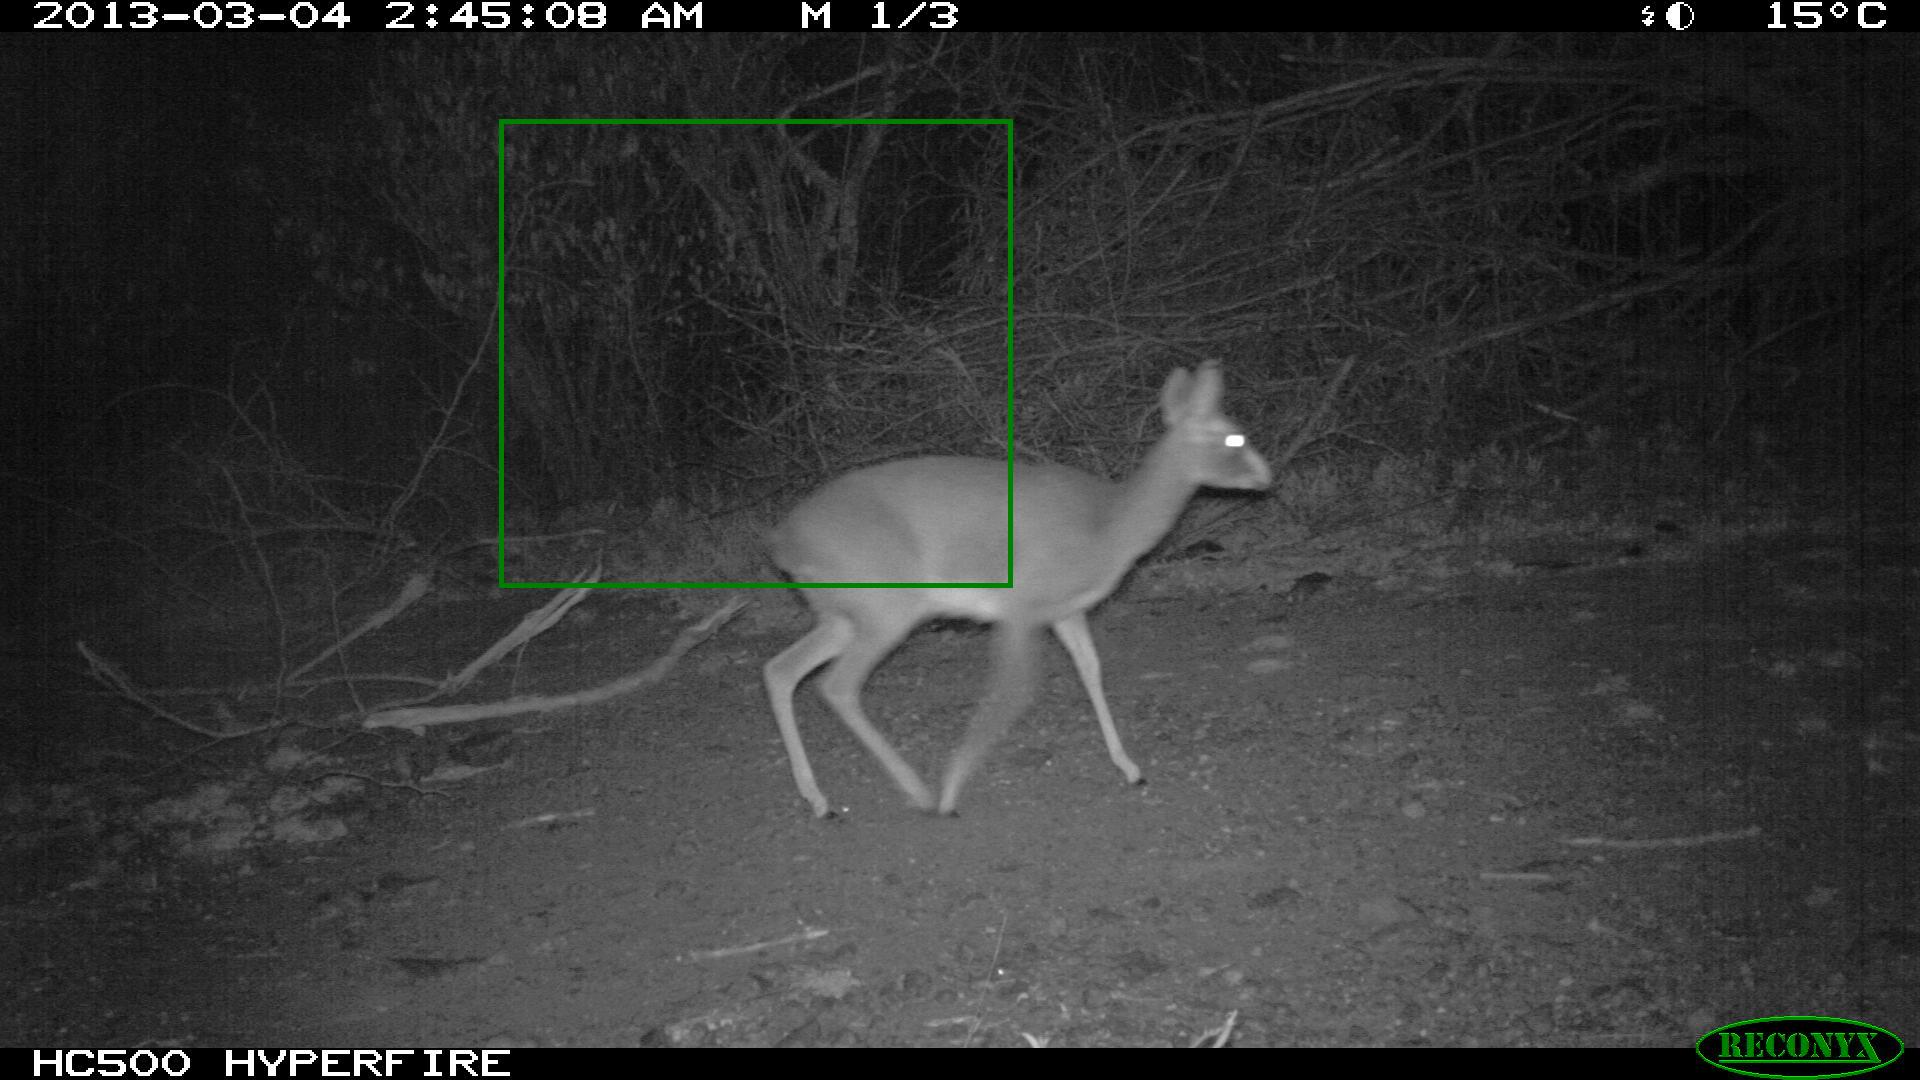

### Actual bounding box

In [33]:
img = read_image(f'{TEST_IMAGES_PATH}/{image_id}.jpg')

bboxes = torch.tensor([test_bbox])

img = draw_bounding_boxes(img, bboxes, colors='green', width=5)
img = torchvision.transforms.ToPILImage()(img)
img.save('data/test.jpg')

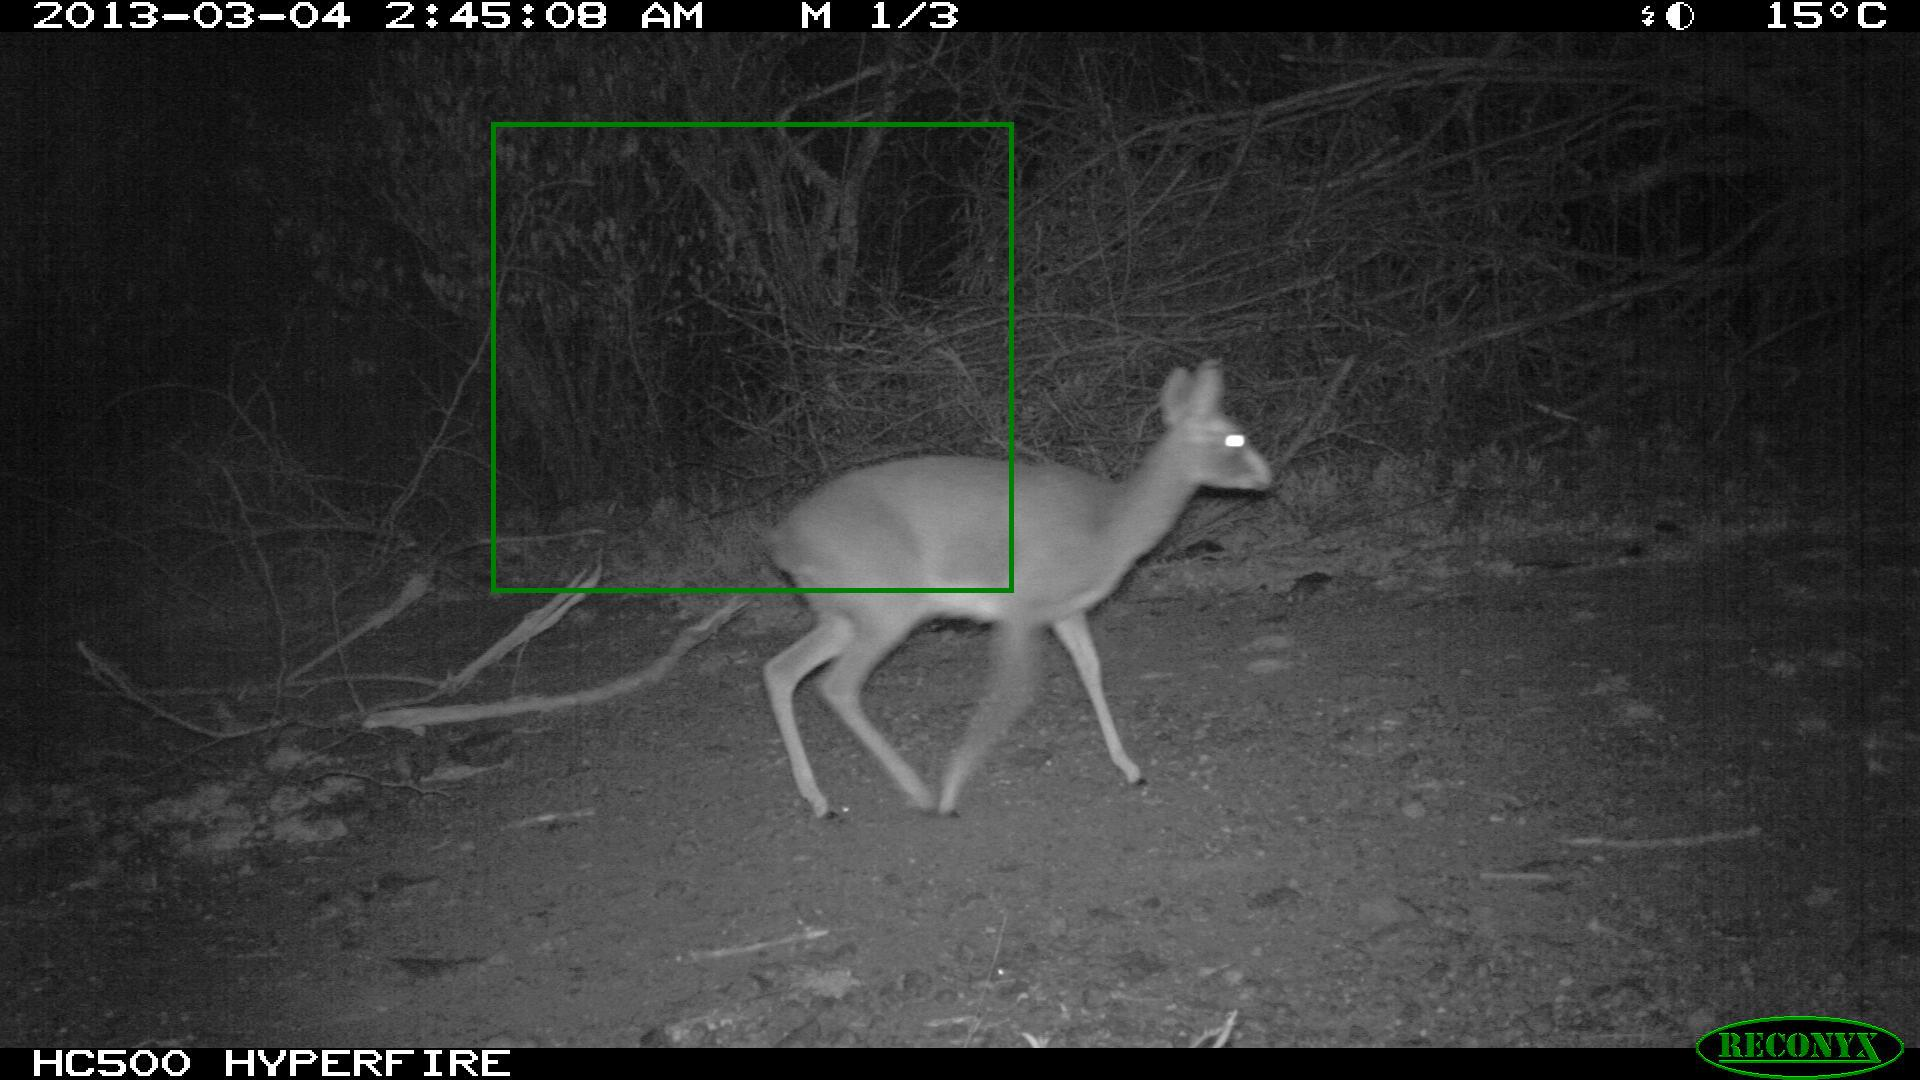